# 1. Importation des librairies

In [ ]:
!pip install osmnx
!pip install networkx
!pip install folium

In [ ]:
import math
import random
import copy
import os
import osmnx as ox
import networkx as nx
import folium
import matplotlib.pyplot as plt
from IPython.display import display
from itertools import permutations
from tqdm import tqdm  # Pour afficher la progression
import numpy as np
import json
from folium.plugins import TimestampedGeoJson

In [ ]:
output_dir = "ALNS_Optimisation"  # Remplacez par le chemin désiré
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 2. Chargement du Réseau Routier Réel

On récupère le réseau routier de la carte de France pour effectuer le trajet :

* Tour Eiffel, Paris, France -> Rue Gabriel Péri, Houilles, France

In [ ]:
start_address = "Tour Eiffel, Paris, France"
end_address = "Houilles, Rue Gabriel Péri, France"

start_point = ox.geocode(start_address)  # (lat, lon)
end_point = ox.geocode(end_address)

margin = 0.05
west = min(start_point[1], end_point[1]) - margin
south = min(start_point[0], end_point[0]) - margin
east  = max(start_point[1], end_point[1]) + margin
north = max(start_point[0], end_point[0]) + margin
bbox = (west, south, east, north)

print("Téléchargement du réseau routier pour la zone couvrant le trajet...")
G = ox.graph_from_bbox(bbox, network_type='drive')

start_osmid = ox.distance.nearest_nodes(G, X=start_point[1], Y=start_point[0])
end_osmid = ox.distance.nearest_nodes(G, X=end_point[1], Y=end_point[0])

Téléchargement du réseau routier pour la zone couvrant le trajet...


# 3. Definition des Classes

* Classe Node : Cette classe constitue la base de notre représentation du réseau routier. Elle permet de définir un point précis sur le réseau en utilisant les informations de position (latitude et longitude). De plus, elle intègre des attributs complémentaires tels que :

    * Identifiant (id) : Un identifiant unique permettant de distinguer chaque noeud.

    * Position géographique (lat, lon) : Les coordonnées géographiques du point, utiles pour le positionnement sur une carte.

    * Indicateur de station de recharge (is_charging_station) : Un booléen permettant d’identifier si le noeud correspond à une station de recharge ou simplement à un point du réseau.

    * Prix de base (price) : Le coût de l’électricité exprimé en €/kWh, qui pourra être utilisé pour simuler les variations tarifaires.

    * Attribut osmid : Une référence optionnelle, par exemple issue d’OpenStreetMap, pour intégrer des données cartographiques externes.

* Classe ChargingStation : Cette classe est une spécialisation de la classe Node, conçue pour représenter une station de recharge électrique. En héritant de Node, elle bénéficie déjà des attributs de position et de tarification, et y ajoute des caractéristiques spécifiques telles que :

    * Énergie restante (Renergie) : La quantité d’électricité disponible à la station pour le chargement.

    * Types de recharge (Rtypes) : Les différentes technologies de recharge proposées (par exemple, AC, DC).

    * Vitesse de chargement (R_vitesse) : La rapidité avec laquelle la station peut charger un véhicule, exprimée en kWh/min.

    * Nombre de connecteurs (Rconnecteurs) : Le nombre total de points de charge disponibles dans la station.

    * Disponibilité (Rdispo) : Un indicateur qui précise si la station est opérationnelle et prête à être utilisée.

    * État d’occupation (occupied) : Un booléen permettant de savoir si la station est déjà occupée, utile pour la gestion des demandes de recharge et la négociation d’accès en temps réel.

* Classe Vehicle : Cette classe modélise le comportement d’un véhicule électrique dans notre simulation. Elle intègre plusieurs attributs essentiels pour suivre et prédire son comportement sur le réseau :

    * Identifiant du véhicule (id) : Un identifiant unique pour différencier chaque véhicule.

    * Capacité maximale de la batterie (Bmax) : La capacité totale de la batterie du véhicule en kWh, indiquant l’autonomie maximale.

    * Niveau actuel de la batterie (Bactuel) : La quantité d’énergie restante dans la batterie, initialisée à une valeur de départ.

    * Consommation énergétique (Ckm) : La consommation d’électricité par kilomètre parcouru (kWh/km), utile pour estimer l’autonomie en fonction de la distance.

    * Vitesse maximale et effective (Vmax, Veff) : La vitesse théorique maximale et la vitesse réellement appliquée dans des conditions de conduite réelles.

    * Temps d’autonomie estimé (Tautonomie) : Une estimation du temps ou de la distance que le véhicule peut parcourir avec l’énergie disponible.

    * Itinéraire (route) : Une liste de noeuds définissant le trajet planifié pour le véhicule.

    * Horaires d’arrivée (arrival_times) : Des indicateurs temporels pour chaque étape du parcours, permettant de simuler la progression du véhicule.

    * Historique des niveaux de batterie (battery_levels) : Un suivi de l’évolution de la charge de la batterie au fil du trajet.

    * Profil de conduite (profile) : Un paramètre permettant de simuler différents comportements de conduite (par exemple, "équilibrer", "économique" ou "sportif"), influençant la gestion de la batterie et la planification des recharges.

    * Heure de départ (start_time) : Un moment de départ initialisé à 0.0, qui sera défini de manière précise lors de la simulation.



In [ ]:
class Node:
    def __init__(self, node_id, lat, lon, is_charging_station=False, price=0):
        self.id = node_id
        self.lat = lat
        self.lon = lon
        self.is_charging_station = is_charging_station
        self.price = price  # prix de base (€/kWh)
        self.osmid = None

class ChargingStation(Node):
    def __init__(self, node_id, lat, lon, price, Renergie, Rtypes, R_vitesse, Rconnecteurs, Rdispo=True):
        super().__init__(node_id, lat, lon, is_charging_station=True, price=price)
        self.Renergie = Renergie
        self.Rtypes = Rtypes
        self.R_vitesse = R_vitesse  # kWh/min
        self.Rconnecteurs = Rconnecteurs
        self.Rdispo = Rdispo

class Vehicle:
    def __init__(self, vehicle_id, Bmax, Ckm, Vmax, Veff, Tautonomie, Binit, profile="equilibrer"):
        self.id = vehicle_id
        self.Bmax = Bmax
        self.Bactuel = Binit
        self.Ckm = Ckm
        self.Vmax = Vmax
        self.Veff = Veff
        self.Tautonomie = Tautonomie
        self.route = []
        self.arrival_times = []
        self.battery_levels = []
        self.profile = profile
        self.start_time = 0.0  # sera défini pour chaque véhicule

#  4. Fonctions Utilitaires

* Un calcul de la distance entre deux points du réseau en s'appuyant sur un algorithme de chemin le plus court, permettant de déterminer la distance en kilomètres.

* Une estimation du temps de trajet, obtenue en divisant cette distance par une vitesse de déplacement par défaut.

* Le calcul du coût énergétique associé à un trajet, en multipliant la distance parcourue par la consommation énergétique du véhicule.

* Une évaluation de la quantité de recharge nécessaire pour combler le déficit de la batterie.

* Une fonction de modulation dynamique du prix de recharge, qui ajuste le tarif de base selon une variation sinusoïdale sur 24 heures, pour simuler l'évolution des tarifs en fonction du temps.

* Enfin, une fonction d'évaluation globale combine ces différents coûts (temps, énergie, recharge) en les pondérant différemment selon le profil de conduite du véhicule (urgent, économique, écologique ou équilibré).

In [ ]:
DEFAULT_SPEED = 60  # km/h

def network_distance(n1, n2, G):
    try:
        length_m = nx.shortest_path_length(G, source=n1.osmid, target=n2.osmid, weight='length')
        return length_m / 1000.0  # en km
    except Exception:
        return float('inf')

def travel_time(n1, n2, G, speed=DEFAULT_SPEED):
    distance = network_distance(n1, n2, G)
    return distance / speed

def energy_cost(n1, n2, vehicle, G):
    distance = network_distance(n1, n2, G)
    return distance * vehicle.Ckm

def recharge_amount(vehicle, current_battery):
    return vehicle.Bmax - current_battery

# Fonction dynamique pour faire varier le prix en fonction du temps (en heures)
def get_dynamic_price(station, current_time):
    amplitude = getattr(station, 'price_amplitude', 0.2)
    phase_shift = getattr(station, 'price_phase_shift', 18)
    return station.price * (1 + amplitude * math.sin(2 * math.pi * (current_time - phase_shift) / 24))

def travel_speed(n1, n2):
    return DEFAULT_SPEED

def compute_objective_cost(vehicle, cost_tuple):
    energy, recharge, ttime = cost_tuple
    profile = vehicle.profile
    alpha = 4.4099
    beta = 0.3267
    teta = 0.0642
    if profile == "urgent":
        return alpha * 0.6 * ttime + beta * 0.2 * energy + teta * 0.2 * recharge
    elif profile == "econome":
        return alpha * 0.2 * ttime + beta * 0.2 * energy + teta * 0.6 * recharge
    elif profile == "vert":
        return alpha * 0.2 * ttime + beta * 0.6 * energy + teta * 0.2 * recharge
    elif profile == "equilibrer":
        return alpha * ttime + beta * energy + teta * recharge
    else:
        return alpha * ttime + beta * energy + teta * recharge

##  4.1 Gestion de l'occupation des bornes

Cette fonction planifie l'événement de recharge d'un véhicule à son arrivée dans une station. En s'appuyant sur un planning global et sur des mises à jour locales, elle détermine si, à l'heure d'arrivée, tous les connecteurs de la station sont occupés. Si c'est le cas, la fonction repousse l'heure de début de la recharge jusqu'à ce qu'un connecteur se libère, calculant ainsi le temps d'attente. Elle met ensuite à jour le planning local avec l'intervalle réservé pour cette recharge et renvoie le temps d'attente calculé.

In [ ]:
def schedule_charging_event(arrival_time, station, t_recharge, global_schedule, local_updates):
    intervals = []
    if global_schedule is not None and station.id in global_schedule:
        intervals.extend(global_schedule[station.id])
    if local_updates is not None and station.id in local_updates:
        intervals.extend(local_updates[station.id])
    def connectors_busy(time):
        return sum(1 for (s, f) in intervals if s <= time < f)
    current_time = arrival_time
    # Boucle d'attente : on avance le temps jusqu'à ce qu'un connecteur soit libre.
    while connectors_busy(current_time) >= station.Rconnecteurs:
        overlapping = [f for (s, f) in intervals if s <= current_time < f]
        if overlapping:
            current_time = min(overlapping)
        else:
            break
    waiting_time = current_time - arrival_time
    start_time_chg = current_time
    finish_time = start_time_chg + t_recharge
    if local_updates is not None:
        if station.id not in local_updates:
            local_updates[station.id] = []
        local_updates[station.id].append((start_time_chg, finish_time))
    return waiting_time

# 5. Evaluation de la Route

La fonction d'évaluation de la route simule le trajet d'un véhicule en tenant compte de sa consommation d'énergie, du temps de parcours et des arrêts éventuels pour recharger. De manière générale, elle :

* Parcourt les segments du trajet, calcule pour chaque étape la distance, le temps de déplacement et l'énergie consommée.

* Met à jour le niveau de batterie et, lorsque celui-ci devient insuffisant, vérifie si le véhicule se trouve dans une station de recharge disponible pour procéder à une recharge.

* Gère la planification de la recharge en intégrant des temps d'attente éventuels (via le planning global et des mises à jour locales) et en appliquant une tarification dynamique en fonction de l'heure.

* Accumule les coûts liés à la consommation énergétique, aux recharges et au temps total de parcours.

* Retourne un ensemble de résultats comprenant le coût objectif (calculé par une fonction de pondération), le détail des coûts, les horaires d'arrivée et les niveaux de batterie à chaque étape, ainsi que, le cas échéant, les mises à jour du planning et les événements de recharge.

In [ ]:
def evaluate_route(vehicle, route, G, start_time=0.0, global_schedule=None):
    total_energy_cost = 0
    total_recharge_cost = 0
    total_time = 0
    battery_level = vehicle.Bactuel
    current_time = start_time
    arrival_times = [current_time]
    battery_levels = [battery_level]
    # Pour gérer l'occupation des connecteurs par réservation
    local_updates = {} if global_schedule is not None else None
    charging_events = [] if global_schedule is not None else None

    for i in range(len(route)-1):
        current = route[i]
        nxt = route[i+1]
        energy_req = energy_cost(current, nxt, vehicle, G)
        # Si le véhicule ne dispose pas d'énergie suffisante dès le départ, la route est invalide.
        if i == 0 and battery_level < energy_req:
            arrival_times.append(current_time + travel_time(current, nxt, G, DEFAULT_SPEED))
            battery_levels.append(battery_level)
            if global_schedule is not None:
                return (None, None, arrival_times, battery_levels, local_updates, charging_events)
            else:
                return (None, None, arrival_times, battery_levels)
        t_travel = travel_time(current, nxt, G, DEFAULT_SPEED)
        total_time += t_travel
        current_time += t_travel
        battery_level -= energy_req
        total_energy_cost += energy_req

        if battery_level < 0:
            # Le véhicule doit se recharger s'il arrive sur une borne rechargeable.
            if i > 0 and current.is_charging_station and current.Rdispo:
                energy_to_recharge = recharge_amount(vehicle, battery_level)
                t_recharge_base = (energy_to_recharge / current.R_vitesse) / 60.0  # en heures
                station_arrival = current_time

                # Vérifier le nombre de connecteurs disponibles au moment de l'arrivée.
                intervals = []
                if global_schedule is not None and current.id in global_schedule:
                    intervals.extend(global_schedule[current.id])
                if local_updates is not None and current.id in local_updates:
                    intervals.extend(local_updates[current.id])
                free_connectors_at_arrival = current.Rconnecteurs - sum(1 for (s, f) in intervals if s <= station_arrival < f)
                if free_connectors_at_arrival < 1:
                    # Si aucun connecteur n'est libre immédiatement, la borne n'est pas accessible.
                    if global_schedule is not None:
                        return (None, None, arrival_times, battery_levels, local_updates, charging_events)
                    else:
                        return (None, None, arrival_times, battery_levels)

                # Réserver l'intervalle de recharge et récupérer le temps d'attente.
                t_wait = 0
                if global_schedule is not None:
                    t_wait = schedule_charging_event(current_time, current, t_recharge_base, global_schedule, local_updates)
                # Si le véhicule doit attendre, on considère la route comme invalide.
                if t_wait > 0:
                    if global_schedule is not None:
                        return (None, None, arrival_times, battery_levels, local_updates, charging_events)
                    else:
                        return (None, None, arrival_times, battery_levels)

                charging_start_time = current_time + t_wait
                # Recalculer les intervalles après réservation pour connaître le nombre de connecteurs libres au démarrage.
                intervals = []
                if global_schedule is not None and current.id in global_schedule:
                    intervals.extend(global_schedule[current.id])
                if local_updates is not None and current.id in local_updates:
                    intervals.extend(local_updates[current.id])
                free_connectors = current.Rconnecteurs - sum(1 for (s, f) in intervals if s <= charging_start_time < f)

                total_time += (t_recharge_base + t_wait)
                current_time += (t_recharge_base + t_wait)
                dynamic_price = get_dynamic_price(current, charging_start_time)
                total_recharge_cost += dynamic_price * energy_to_recharge
                battery_level = vehicle.Bmax
                if charging_events is not None:
                    charging_events.append({
                        "station_id": current.id,
                        "arrival_time": station_arrival,
                        "free_connectors": free_connectors,
                        "t_recharge_base": t_recharge_base,
                        "t_wait": t_wait,
                        "total_time_at_station": t_recharge_base + t_wait,
                        "dynamic_price": dynamic_price
                    })
            else:
                # Si le véhicule n'est pas sur une borne rechargeable ou la borne n'est pas dispo, la route est invalide.
                if global_schedule is not None:
                    return (None, None, arrival_times, battery_levels, local_updates, charging_events)
                else:
                    return (None, None, arrival_times, battery_levels)
        arrival_times.append(current_time)
        battery_levels.append(battery_level)
    cost_tuple = (total_energy_cost, total_recharge_cost, total_time)
    objective_cost = compute_objective_cost(vehicle, cost_tuple)
    if global_schedule is not None:
        return (objective_cost, cost_tuple, arrival_times, battery_levels, local_updates, charging_events)
    else:
        return (objective_cost, cost_tuple, arrival_times, battery_levels)

# 6. Solution Initiale et Opérateurs ALNS

Cette section regroupe l'ensemble des fonctions qui constituent la démarche d'optimisation par ALNS (Adaptive Large Neighborhood Search) appliquée à la planification de la route. Globalement, le processus se décompose en plusieurs étapes :

* Génération d'une solution initiale :
On commence par établir une route simple reliant le point de départ à l'arrivée. Si cette solution de base s'avère non réalisable (par exemple, en raison de contraintes de batterie), le système explore des solutions alternatives en insérant, de manière sélective, des points intermédiaires susceptibles d'améliorer la faisabilité et l'efficacité globale du trajet.

* Opérateurs de destruction et de réparation :
Un opérateur de destruction retire aléatoirement une partie des points intermédiaires de la route existante, tandis qu'un opérateur de réparation propose de réinsérer ces points retirés en testant diverses combinaisons. L'objectif est de réduire progressivement le coût objectif, qui combine le coût énergétique, le coût de recharge et le temps de trajet, et ce en fonction du profil de conduite du véhicule.

* Itération et amélioration continue :
La méthode ALNS applique ces opérateurs de manière itérative sur un nombre déterminé de cycles. À chaque itération, la solution courante est évaluée et mise à jour si une amélioration est détectée. Ce mécanisme adaptatif permet de converger vers une route optimisée qui respecte à la fois les contraintes de recharge et les performances attendues du véhicule.

* Affichage et visualisation :
Des fonctions complémentaires permettent de formater et d'afficher les informations clés de la route (coûts, horaires d'arrivée, niveaux de batterie) ainsi que de visualiser le trajet sur une carte, facilitant ainsi l'analyse des résultats de la simulation.

In [ ]:
def initial_solution(vehicle, nodes, start_time=0.0, global_schedule=None):
    route = [nodes[0], nodes[-1]]
    if global_schedule is not None:
        result = evaluate_route(vehicle, route, G, start_time, global_schedule)
        obj_current, cost_current, arrivals, battery, local_updates, charging_events = result
    else:
        result = evaluate_route(vehicle, route, G, start_time)
        obj_current, cost_current, arrivals, battery = result
    if obj_current is None:
        feasible = []
        for node in nodes[1:-1]:
            temp_route = [nodes[0], node, nodes[-1]]
            if global_schedule is not None:
                result_temp = evaluate_route(vehicle, temp_route, G, start_time, global_schedule)
                obj_temp, _, _, _, _, _ = result_temp
            else:
                result_temp = evaluate_route(vehicle, temp_route, G, start_time)
                obj_temp, _, _, _ = result_temp
            if obj_temp is not None:
                feasible.append((node, obj_temp))
        if feasible:
            feasible.sort(key=lambda x: x[1])
            best_node = feasible[0][0]
            route = [nodes[0], best_node, nodes[-1]]
    candidates = nodes[1:-1]
    for node in candidates:
        if node in route:
            continue
        best_obj = float('inf')
        best_position = None
        for i in range(1, len(route)):
            temp_route = route[:i] + [node] + route[i:]
            if global_schedule is not None:
                result_temp = evaluate_route(vehicle, temp_route, G, start_time, global_schedule)
                obj_temp, _, _, _, _, _ = result_temp
                result_current = evaluate_route(vehicle, route, G, start_time, global_schedule)
                obj_current, _, _, _, _, _ = result_current
            else:
                result_temp = evaluate_route(vehicle, temp_route, G, start_time)
                obj_temp, _, _, _ = result_temp
                result_current = evaluate_route(vehicle, route, G, start_time)
                obj_current, _, _, _ = result_current
            if obj_temp is not None and (obj_current is None or obj_temp < obj_current) and obj_temp < best_obj:
                best_obj = obj_temp
                best_position = i
        if best_position is not None:
            route.insert(best_position, node)
    vehicle.route = route
    return route

def destruction_operator(route, removal_rate=0.3):
    if len(route) <= 2:
        return route, []
    new_route = route.copy()
    indices = list(range(1, len(route)-1))
    num_to_remove = int(len(indices) * removal_rate)
    if num_to_remove < 1:
        num_to_remove = 1
    if num_to_remove > len(indices):
        num_to_remove = len(indices)
    remove_indices = random.sample(indices, num_to_remove)
    removed_nodes = []
    for idx in sorted(remove_indices, reverse=True):
        removed_nodes.append(new_route.pop(idx))
    return new_route, removed_nodes

def repair_operator_grouped(route, removed_nodes, vehicle, start_time=0.0, global_schedule=None):
    best_route = None
    best_obj = float('inf')
    if removed_nodes and len(removed_nodes) <= 4:
        for perm in permutations(removed_nodes):
            candidate_route = route.copy()
            valid = True
            for node in perm:
                best_increase = float('inf')
                best_position = None
                for i in range(1, len(candidate_route)):
                    temp_route = candidate_route[:i] + [node] + candidate_route[i:]
                    if global_schedule is not None:
                        result_temp = evaluate_route(vehicle, temp_route, G, start_time, global_schedule)
                        obj_temp, _, _, _, _, _ = result_temp
                    else:
                        result_temp = evaluate_route(vehicle, temp_route, G, start_time)
                        obj_temp, _, _, _ = result_temp
                    if obj_temp is not None and obj_temp < best_increase:
                        best_increase = obj_temp
                        best_position = i
                if best_position is not None:
                    candidate_route.insert(best_position, node)
                else:
                    valid = False
                    break
            if valid:
                if global_schedule is not None:
                    result_candidate = evaluate_route(vehicle, candidate_route, G, start_time, global_schedule)
                    obj_candidate, _, _, _, _, _ = result_candidate
                else:
                    result_candidate = evaluate_route(vehicle, candidate_route, G, start_time)
                    obj_candidate, _, _, _ = result_candidate
                if obj_candidate is not None and obj_candidate < best_obj:
                    best_obj = obj_candidate
                    best_route = candidate_route.copy()
        if best_route is not None:
            return best_route
    candidate_route = route.copy()
    for node in removed_nodes:
        best_increase = float('inf')
        best_position = None
        for i in range(1, len(candidate_route)):
            temp_route = candidate_route[:i] + [node] + candidate_route[i:]
            if global_schedule is not None:
                result_temp = evaluate_route(vehicle, temp_route, G, start_time, global_schedule)
                obj_temp, _, _, _, _, _ = result_temp
                result_current = evaluate_route(vehicle, candidate_route, G, start_time, global_schedule)
                obj_current, _, _, _, _, _ = result_current
            else:
                result_temp = evaluate_route(vehicle, temp_route, G, start_time)
                obj_temp, _, _, _ = result_temp
                result_current = evaluate_route(vehicle, candidate_route, G, start_time)
                obj_current, _, _, _ = result_current
            if obj_temp is not None and (obj_current is None or obj_temp < obj_current):
                if obj_temp < best_increase:
                    best_increase = obj_temp
                    best_position = i
        if best_position is not None:
            candidate_route.insert(best_position, node)
    return candidate_route

def alns(vehicle, initial_route, iterations=100, removal_rate=0.3, start_time=0.0, global_schedule=None):
    current_route = initial_route.copy()
    best_route = None
    best_obj = float('inf')
    if global_schedule is not None:
        result = evaluate_route(vehicle, current_route, G, start_time, global_schedule)
        obj_current, cost_current, arr, bat, local_updates, charging_events = result
    else:
        result = evaluate_route(vehicle, current_route, G, start_time)
        obj_current, cost_current, arr, bat = result
    if obj_current is not None:
        best_route = current_route.copy()
        best_obj = obj_current
        best_arrivals = arr
        best_battery = bat
    for it in tqdm(range(iterations), desc=f"ALNS pour véhicule {vehicle.id}"):
        partial_route, removed_nodes = destruction_operator(current_route, removal_rate)
        new_route = repair_operator_grouped(partial_route, removed_nodes, vehicle, start_time, global_schedule)
        if global_schedule is not None:
            result_new = evaluate_route(vehicle, new_route, G, start_time, global_schedule)
            obj_new, cost_new, new_arrivals, new_battery, local_updates, charging_events = result_new
        else:
            result_new = evaluate_route(vehicle, new_route, G, start_time)
            obj_new, cost_new, new_arrivals, new_battery = result_new
        if obj_new is not None:
            if best_obj is None or obj_new < best_obj:
                best_route = new_route.copy()
                best_obj = obj_new
                best_arrivals = new_arrivals
                best_battery = new_battery
                print(f"Itération {it}: Amélioration trouvée, coût objectif = {best_obj}")
        current_route = new_route.copy()
    if best_route is None:
        best_route = current_route.copy()
        if global_schedule is not None:
            result_best = evaluate_route(vehicle, best_route, G, start_time, global_schedule)
            obj_best, cost_best, best_arrivals, best_battery, local_updates, charging_events = result_best
        else:
            result_best = evaluate_route(vehicle, best_route, G, start_time)
            obj_best, cost_best, best_arrivals, best_battery = result_best
    vehicle.route = best_route
    vehicle.arrival_times = best_arrivals
    vehicle.battery_levels = best_battery
    return best_route, best_obj

def format_time(t):
    try:
        hours = int(t)
        minutes = int(round((t - hours) * 60))
        return f"{hours:02d}:{minutes:02d}"
    except (ValueError, OverflowError):
        return "NA"

def display_route_info(route, vehicle, G, label="", start_time=0.0, global_schedule=None):
    if global_schedule is not None:
        result = evaluate_route(vehicle, route, G, start_time, global_schedule)
        obj, cost, arrivals, battery, local_updates, charging_events = result
    else:
        result = evaluate_route(vehicle, route, G, start_time)
        obj, cost, arrivals, battery = result
    if obj is None:
        energy = "NA"
        recharge = "NA"
        travel_t = "NA"
        total_sum = "NA"
        arrivals_str = ["NA" for _ in arrivals]
    else:
        energy = f"{cost[0]:.2f} kWh"
        recharge = f"{cost[1]:.2f} €"
        travel_t = format_time(cost[2])
        total_sum = f"{(cost[0] + cost[1] + cost[2]):.2f}"
        arrivals_str = [format_time(t) for t in arrivals]
    print(f"--- {label} ---")
    print("Route (IDs):", [node.id for node in route])
    print("Coût énergétique:", energy)
    print("Coût recharge:", recharge)
    print("Temps de trajet:", travel_t)
    print("Coût total (détail):", total_sum)
    print("Coût objectif (pondéré):", obj)
    print("Heures d'arrivée:", arrivals_str)
    print("Niveaux de batterie:", battery)
    if global_schedule is not None and charging_events:
        print("\nDétails des arrêts de recharge :")
        for ce in charging_events:
            print(f"  - Station ID {ce['station_id']}: Arrivée à {format_time(ce['arrival_time'])}, "
                  f"Connecteurs libres: {ce.get('free_connectors', 'NA')}, "
                  f"Recharge de base: {ce['t_recharge_base']*60:.1f} min, "
                  f"Attente: {ce['t_wait']*60:.1f} min, "
                  f"Temps total: {ce['total_time_at_station']*60:.1f} min, "
                  f"Prix dynamique: {ce['dynamic_price']:.2f} €/kWh")
    print()


In [ ]:
def plot_route(route, G):
    if not route:
        return
    avg_lat = sum(node.lat for node in route) / len(route)
    avg_lon = sum(node.lon for node in route) / len(route)
    m = folium.Map(location=[avg_lat, avg_lon], zoom_start=13)
    for node in route:
        color = "green" if node.is_charging_station else "blue"
        popup_text = f"ID: {node.id}"
        if node.is_charging_station:
            popup_text += f"<br>Prix de base: {node.price} €/kWh"
        folium.Marker(location=[node.lat, node.lon],
                      popup=popup_text,
                      icon=folium.Icon(color=color)).add_to(m)
    for i in range(len(route)-1):
        source = route[i]
        target = route[i+1]
        try:
            shortest_path = nx.shortest_path(G, source=source.osmid, target=target.osmid, weight='length')
            path_coords = [[G.nodes[n]['y'], G.nodes[n]['x']] for n in shortest_path]
            folium.PolyLine(locations=path_coords, color="red", weight=3).add_to(m)
        except Exception as e:
            print(f"Erreur entre {source.id} et {target.id}: {e}")
    display(m)

# 7. Affichage des Informations sur les Bornes (statique)

In [ ]:
print("\n----- Informations sur les Bornes -----")
print(f"Station ID {start_osmid} (Départ) : Coordonnées ({start_point[0]}, {start_point[1]}), "
      f"Prix de base: 0.20 €/kWh, Energie dispo: 500 kWh, Vitesse de charge: 30 kWh/min, Connecteurs: 2, Disponible: True")


----- Informations sur les Bornes -----
Station ID 6900473051 (Départ) : Coordonnées (48.8582599, 2.2945006358633115), Prix de base: 0.20 €/kWh, Energie dispo: 500 kWh, Vitesse de charge: 30 kWh/min, Connecteurs: 2, Disponible: True


# 8.1 Création des Nœuds et de la Flotte
# 8.2 Affichage graphiques comparatifs des bornes et de la flotte


Station ID 100 : Coordonnées (48.88474044105518, 2.293192538017191), Prix de base: 0.26 €/kWh, Energie dispo: 367 kWh, Vitesse de charge: 1.7 kWh/min, Connecteurs: 3, Disponible: True
Station ID 101 : Coordonnées (48.92872589864165, 2.193285011768969), Prix de base: 0.26 €/kWh, Energie dispo: 343 kWh, Vitesse de charge: 1.1 kWh/min, Connecteurs: 1, Disponible: True
Station ID 102 : Coordonnées (48.867841252823865, 2.3470145495623522), Prix de base: 0.18 €/kWh, Energie dispo: 347 kWh, Vitesse de charge: 1.9 kWh/min, Connecteurs: 3, Disponible: True
Station ID 103 : Coordonnées (48.877317876641825, 2.3331827008022077), Prix de base: 0.18 €/kWh, Energie dispo: 417 kWh, Vitesse de charge: 1.7 kWh/min, Connecteurs: 3, Disponible: True
Station ID 104 : Coordonnées (48.93989384342026, 2.257952771052331), Prix de base: 0.27 €/kWh, Energie dispo: 461 kWh, Vitesse de charge: 1.1 kWh/min, Connecteurs: 3, Disponible: True
Station ID 105 : Coordonnées (48.89682178943468, 2.201610986743239), Prix de

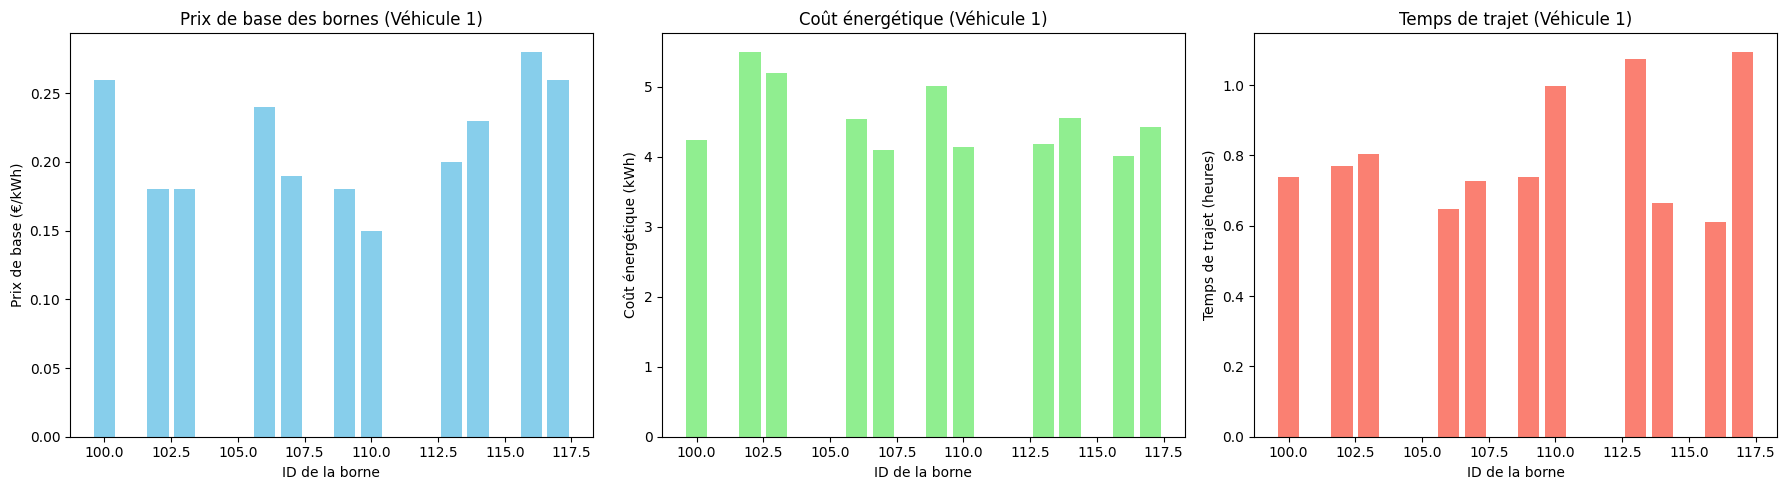

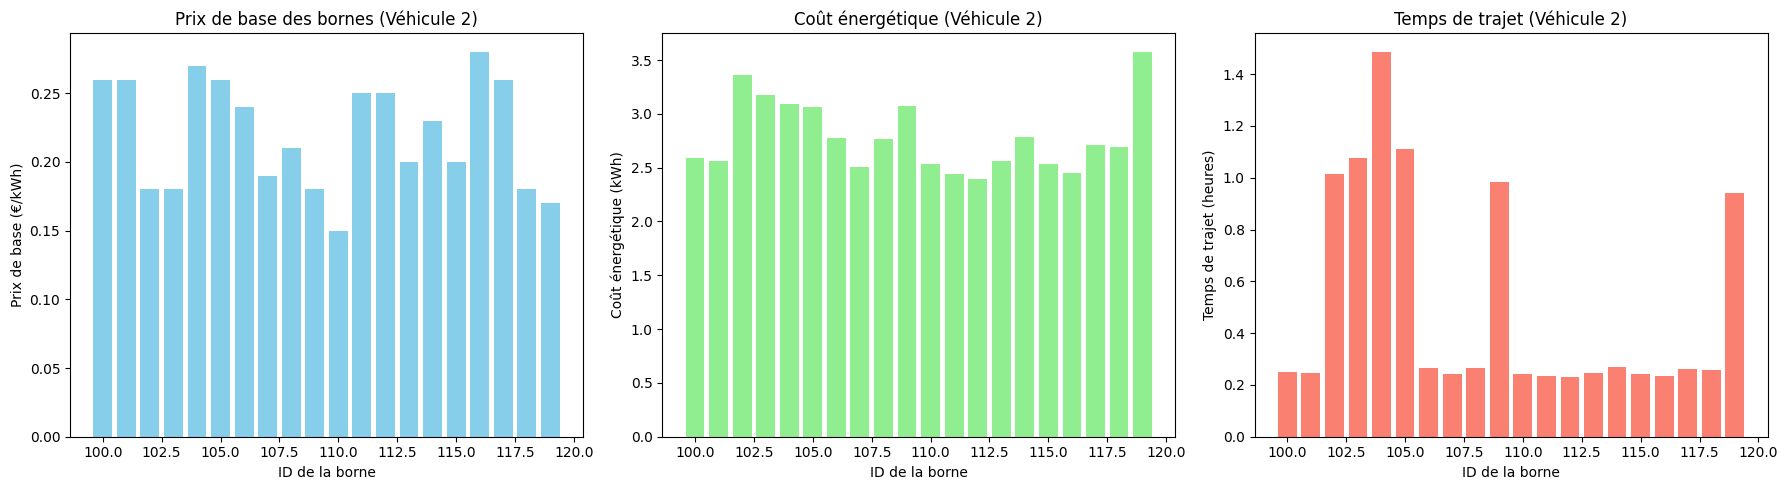

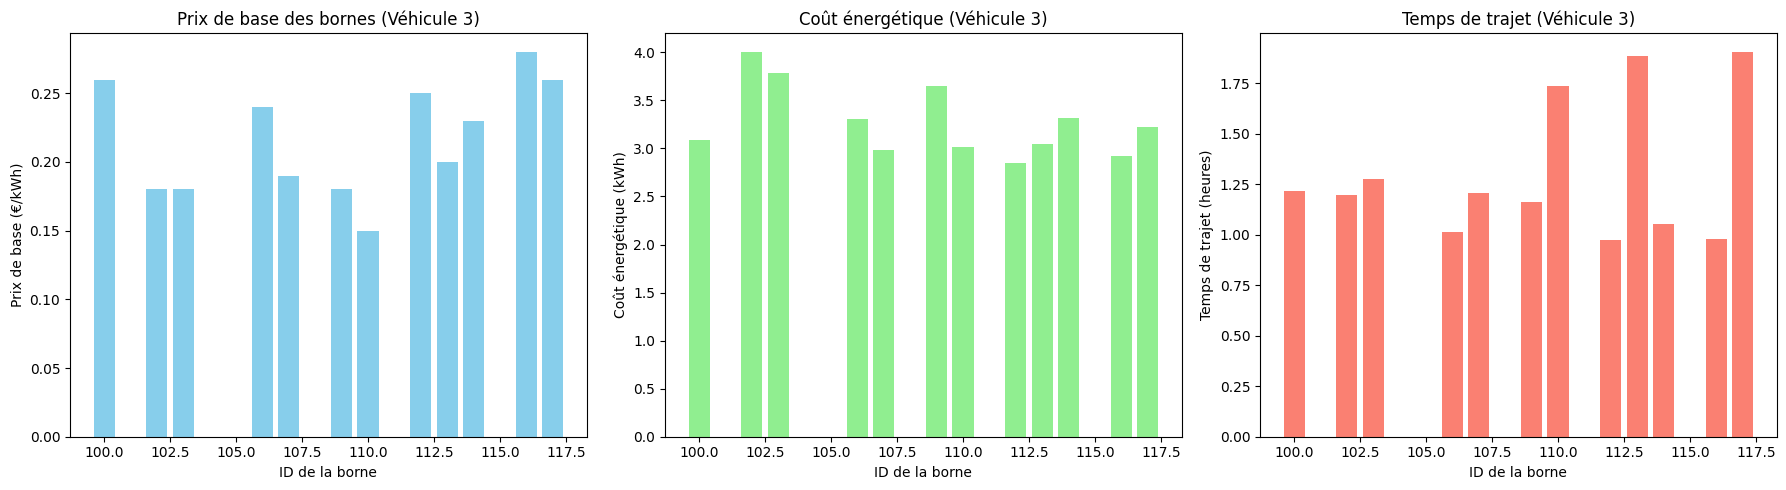

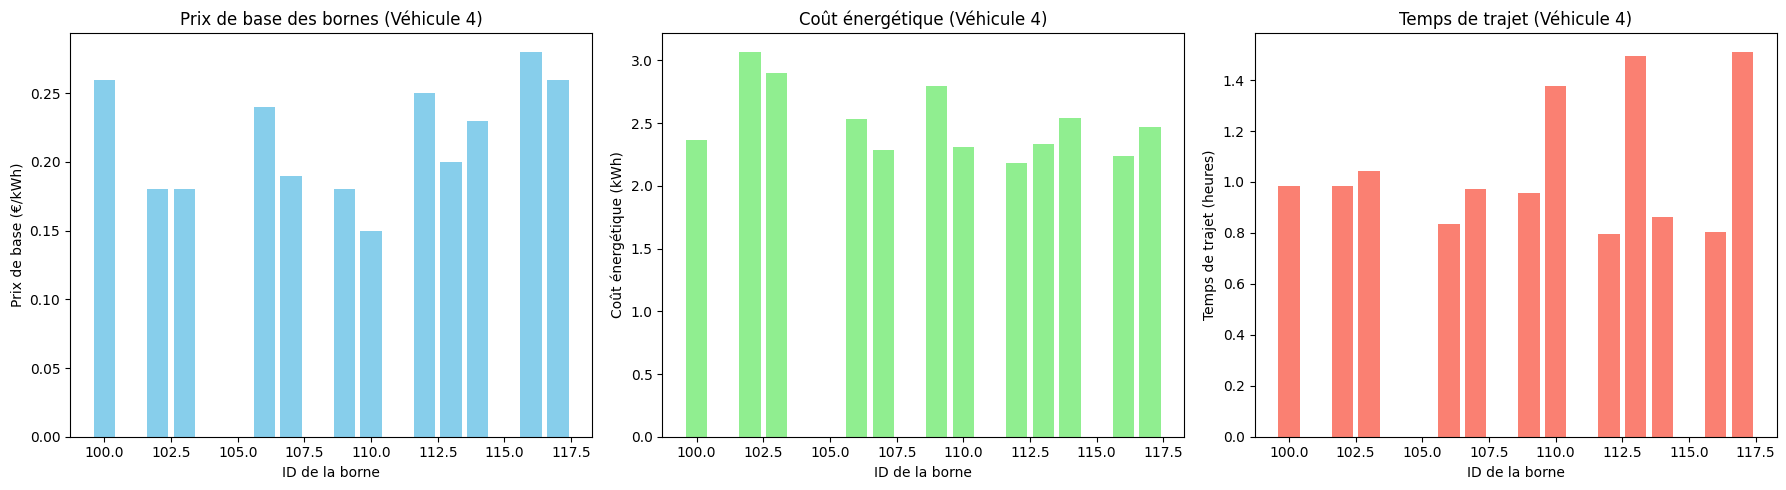

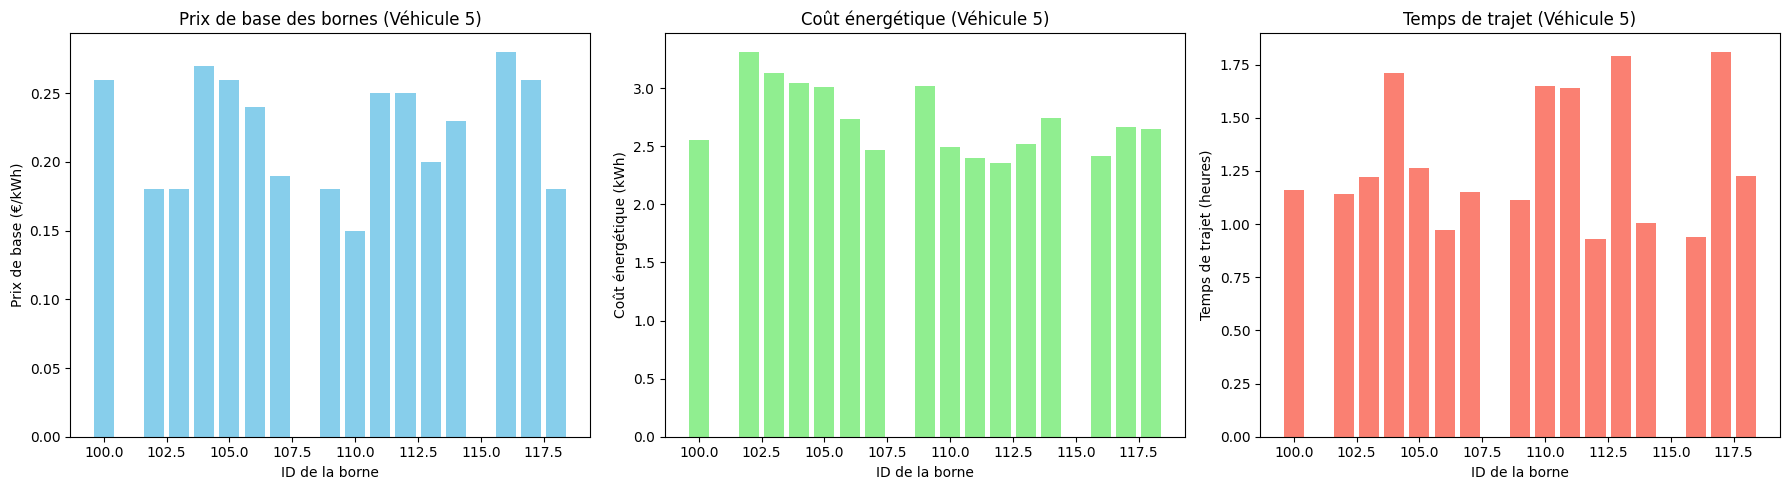

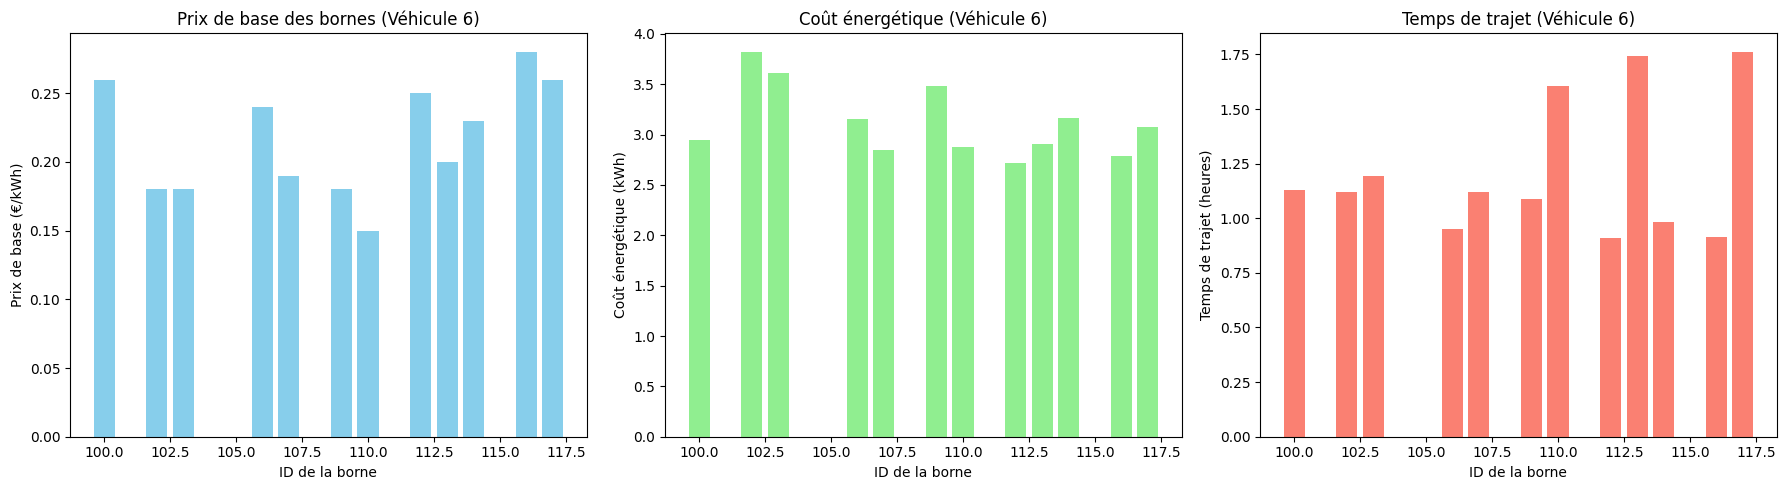

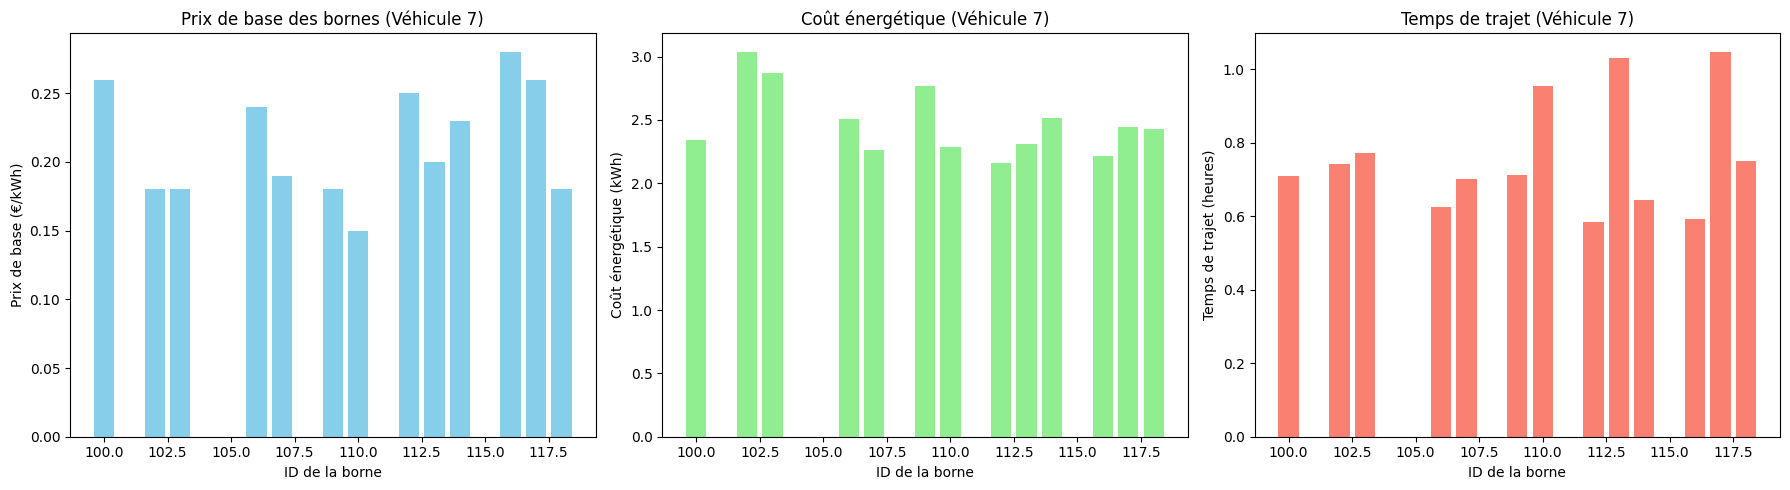

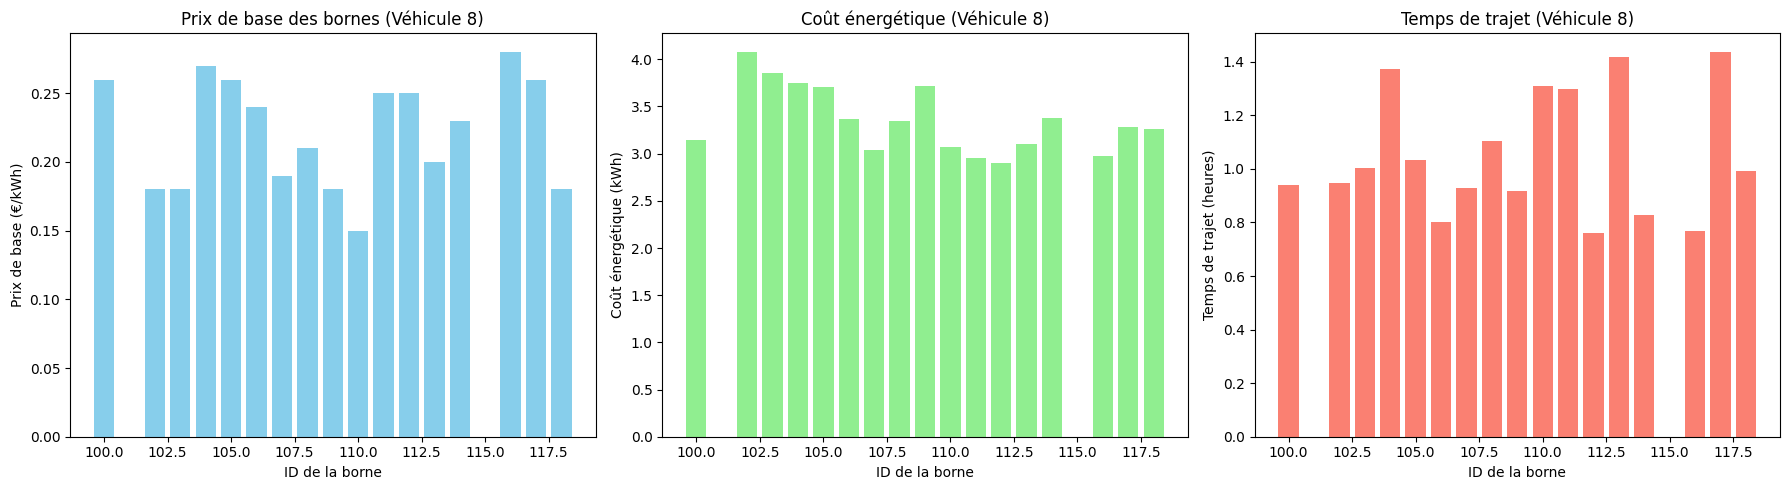

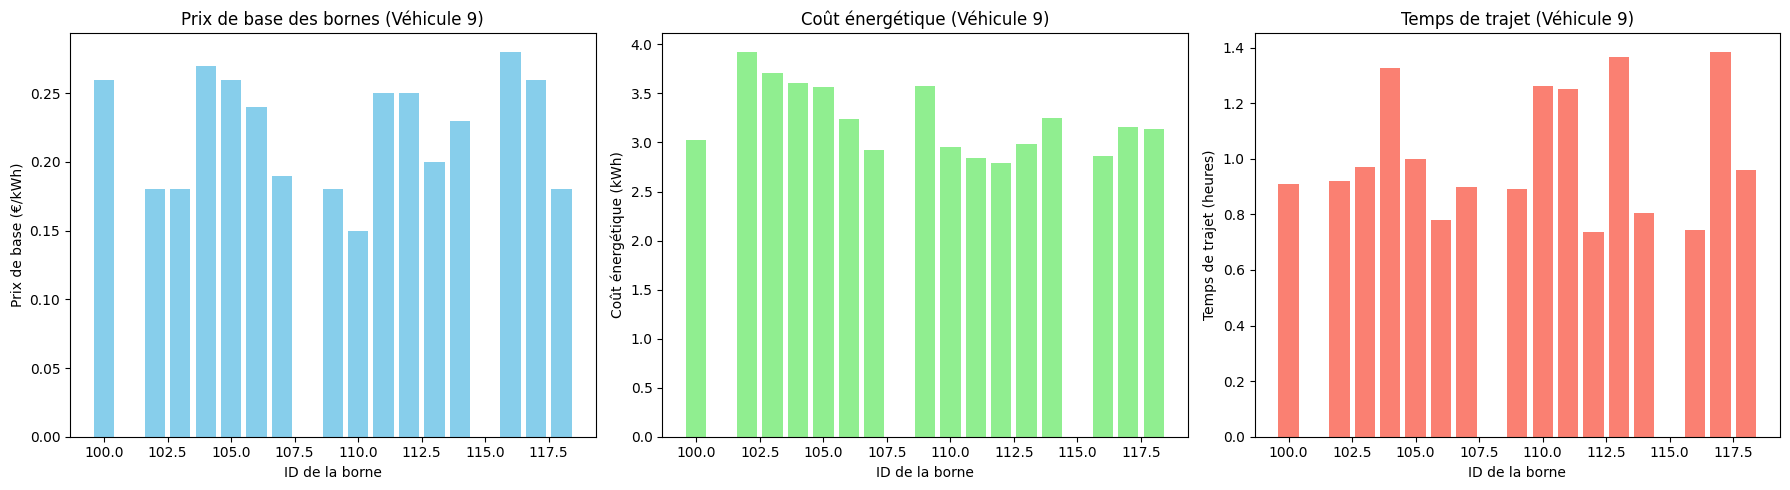

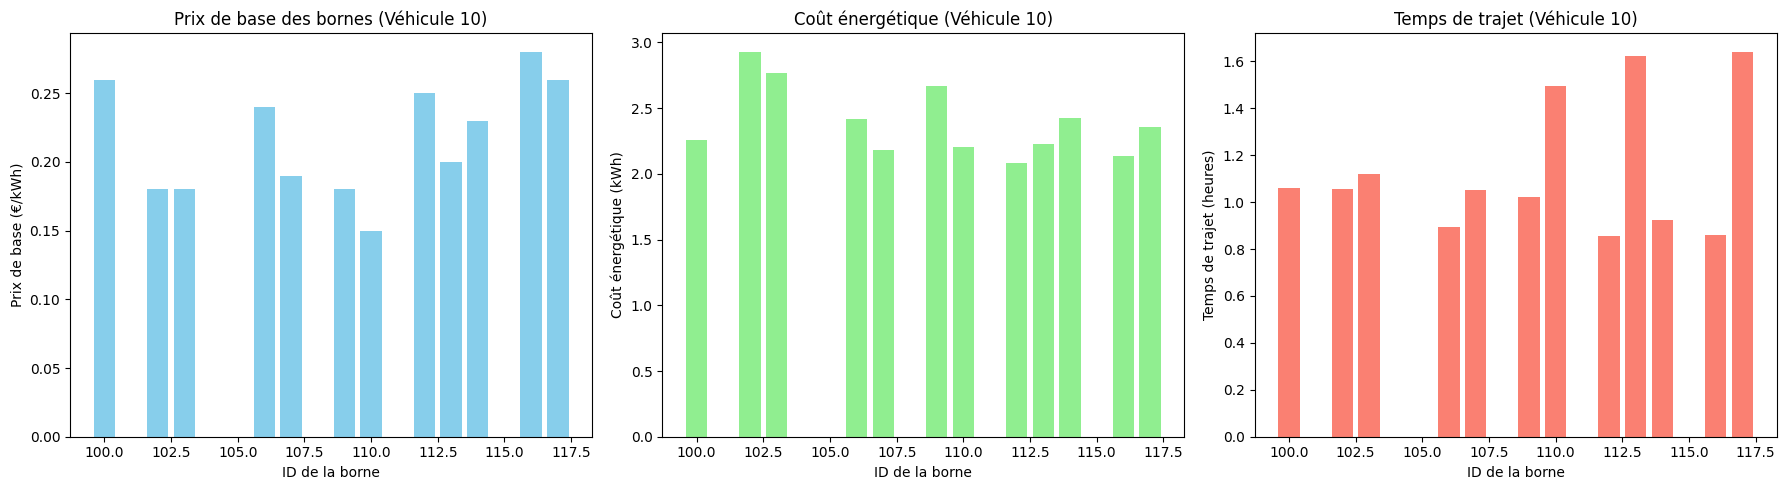

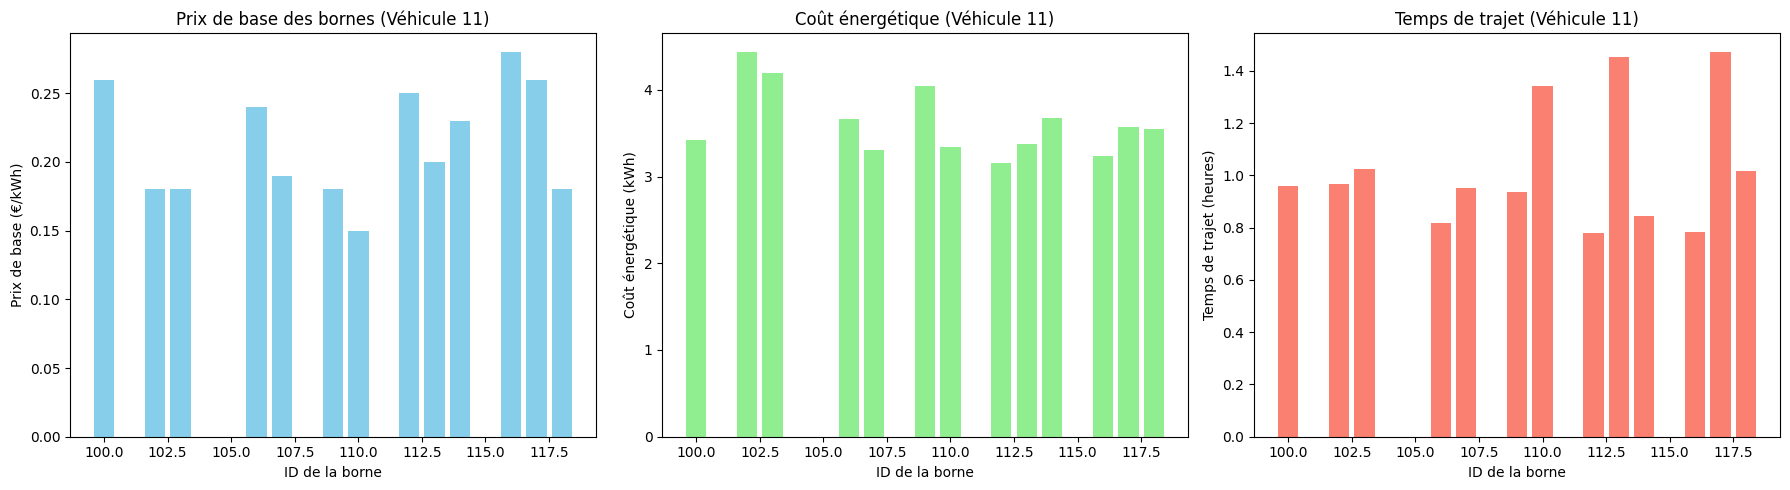

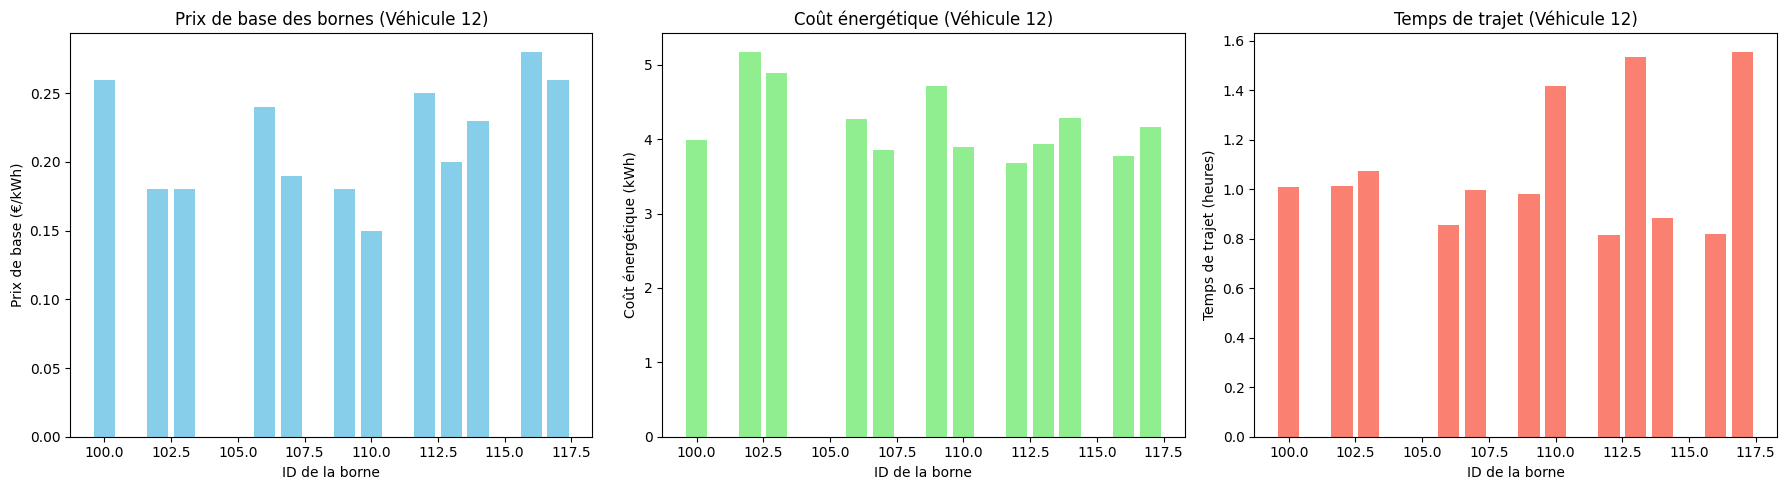

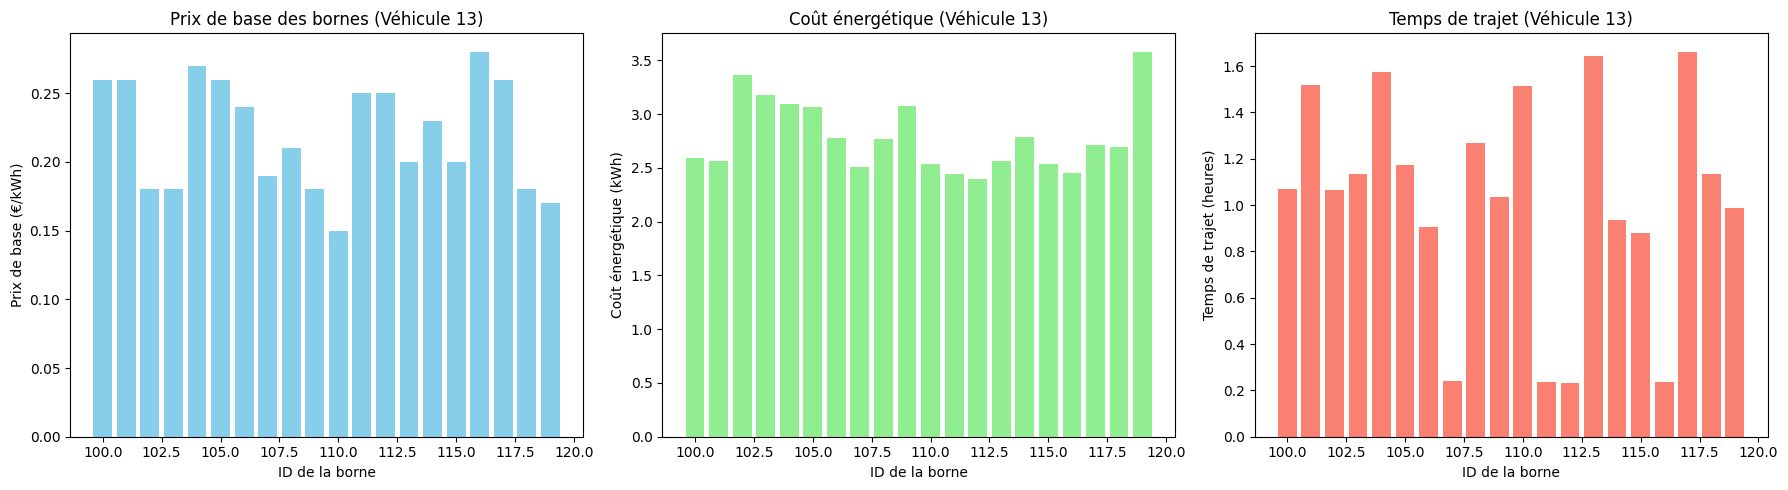

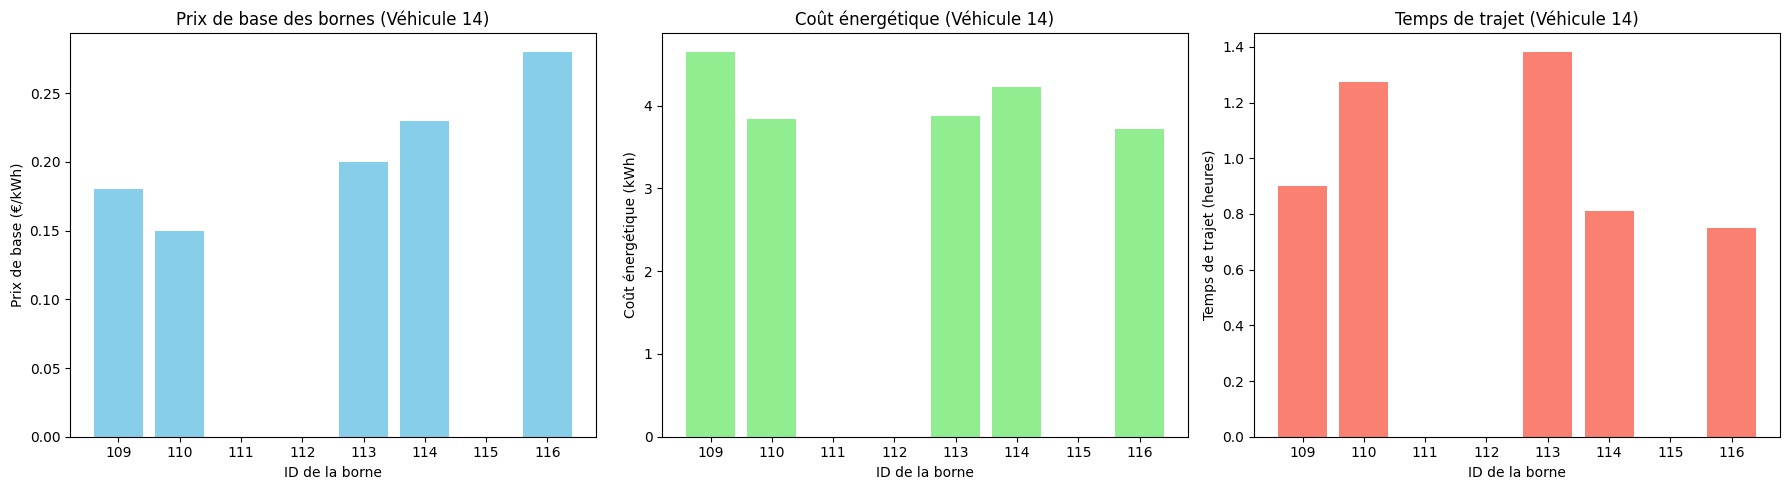

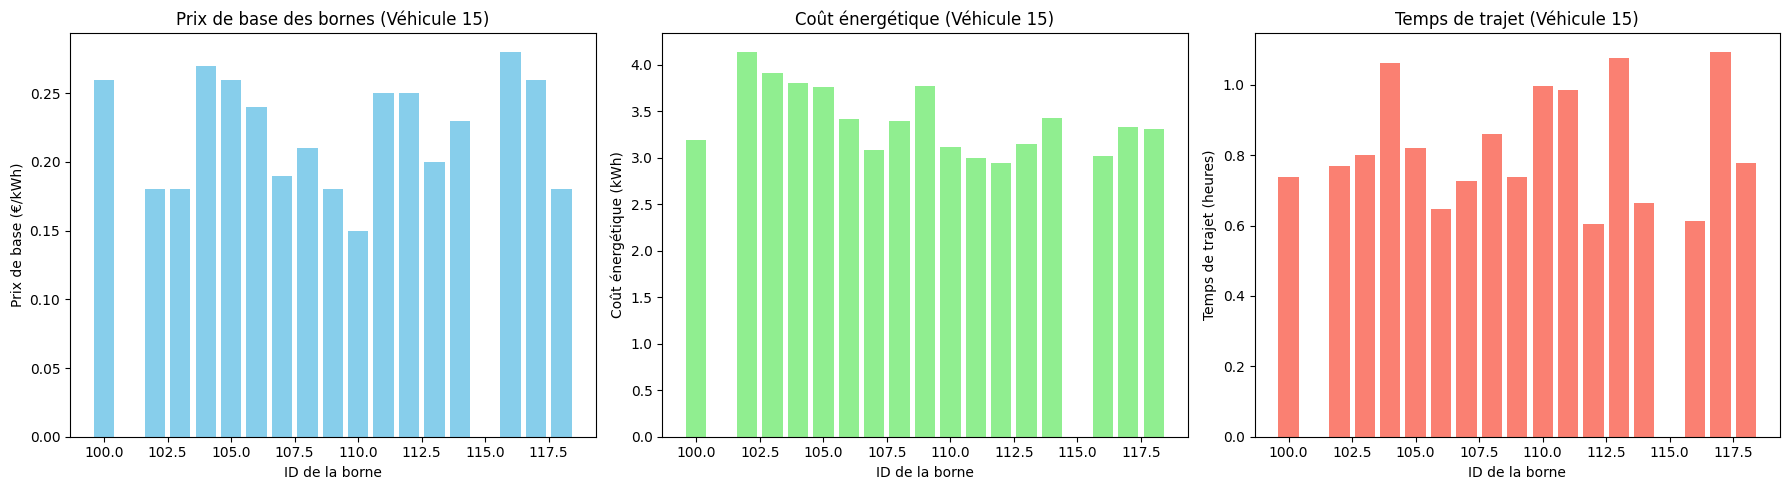

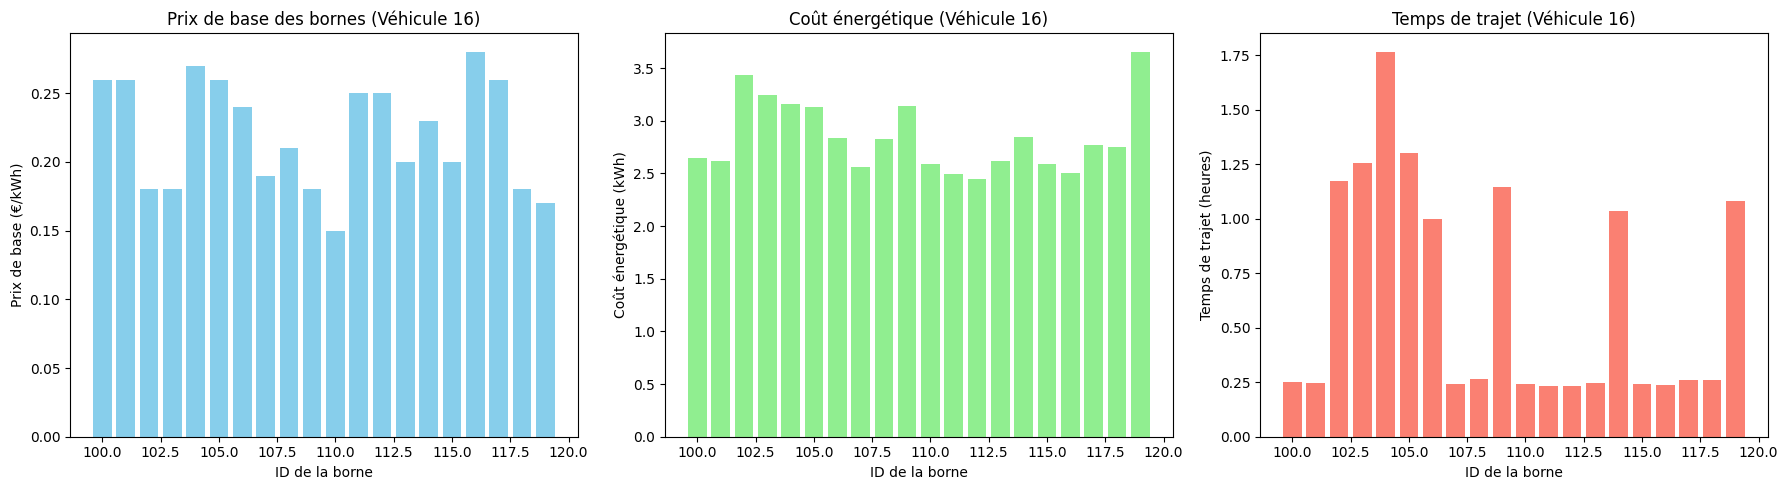

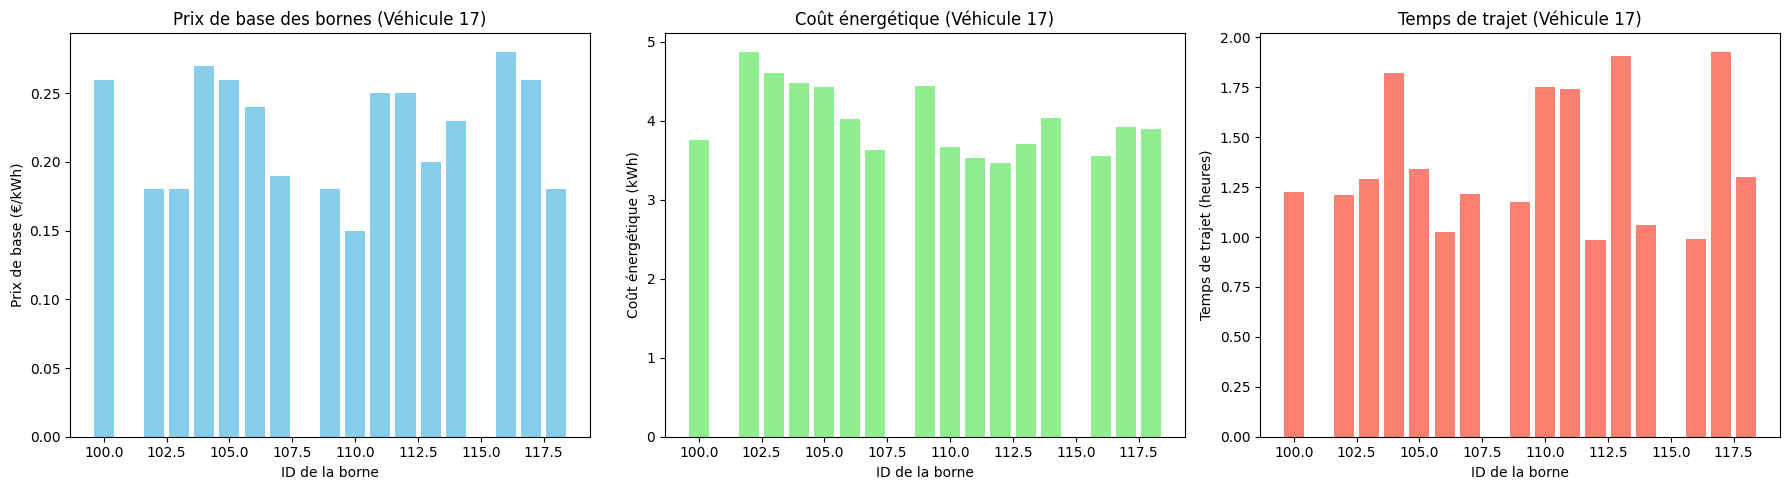

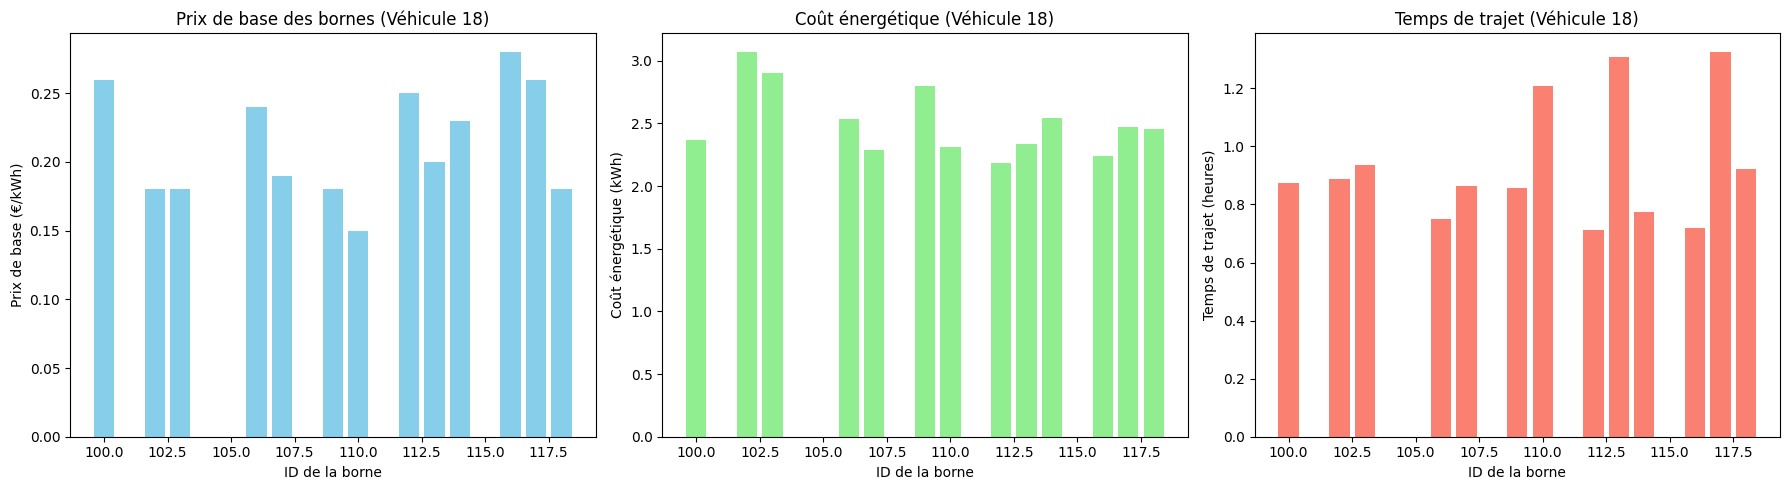

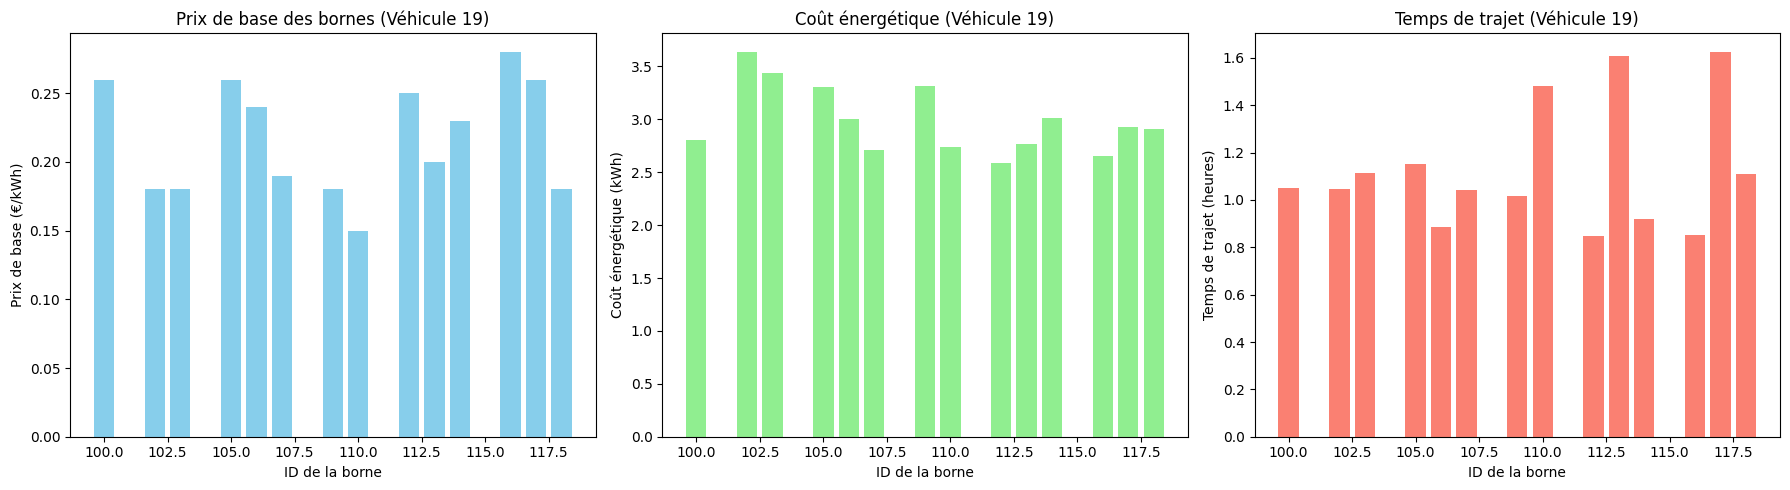

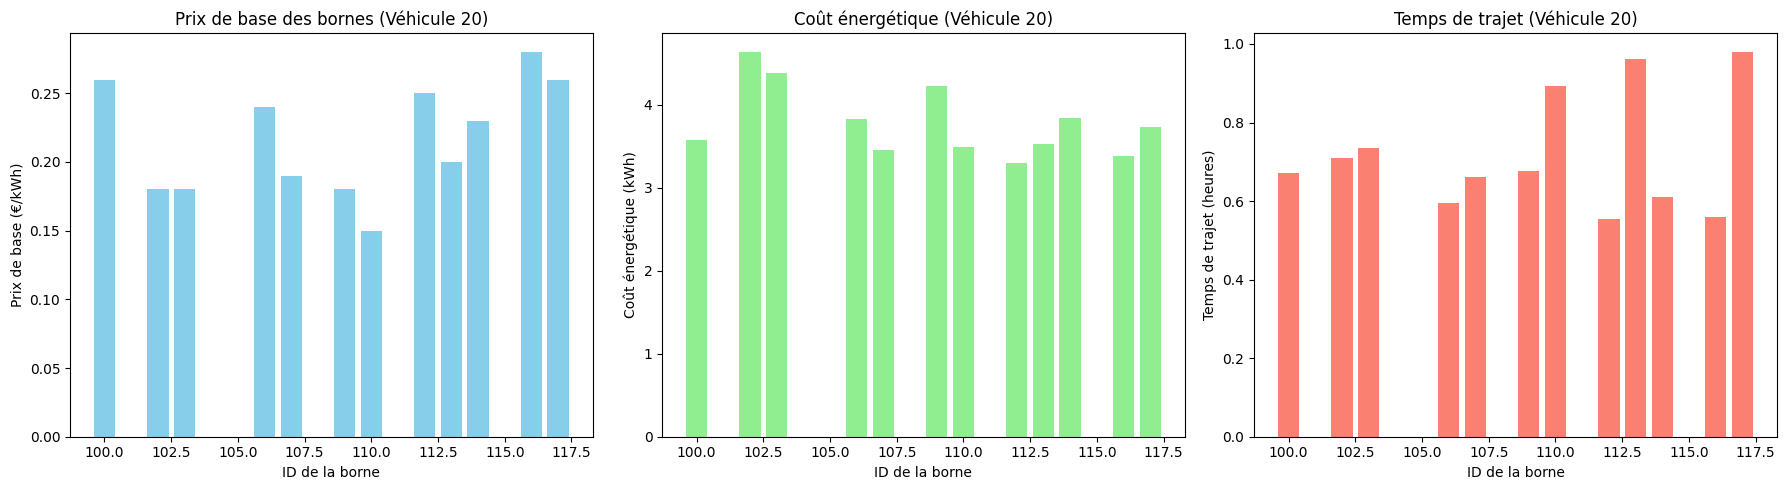

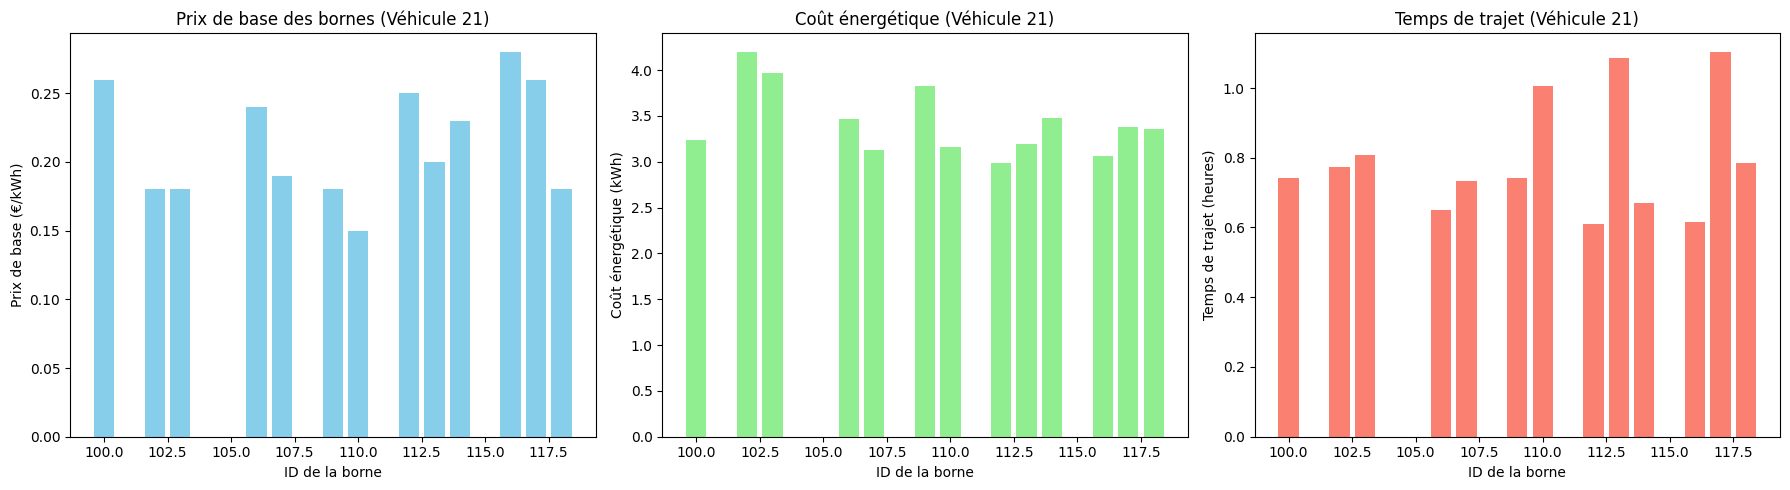

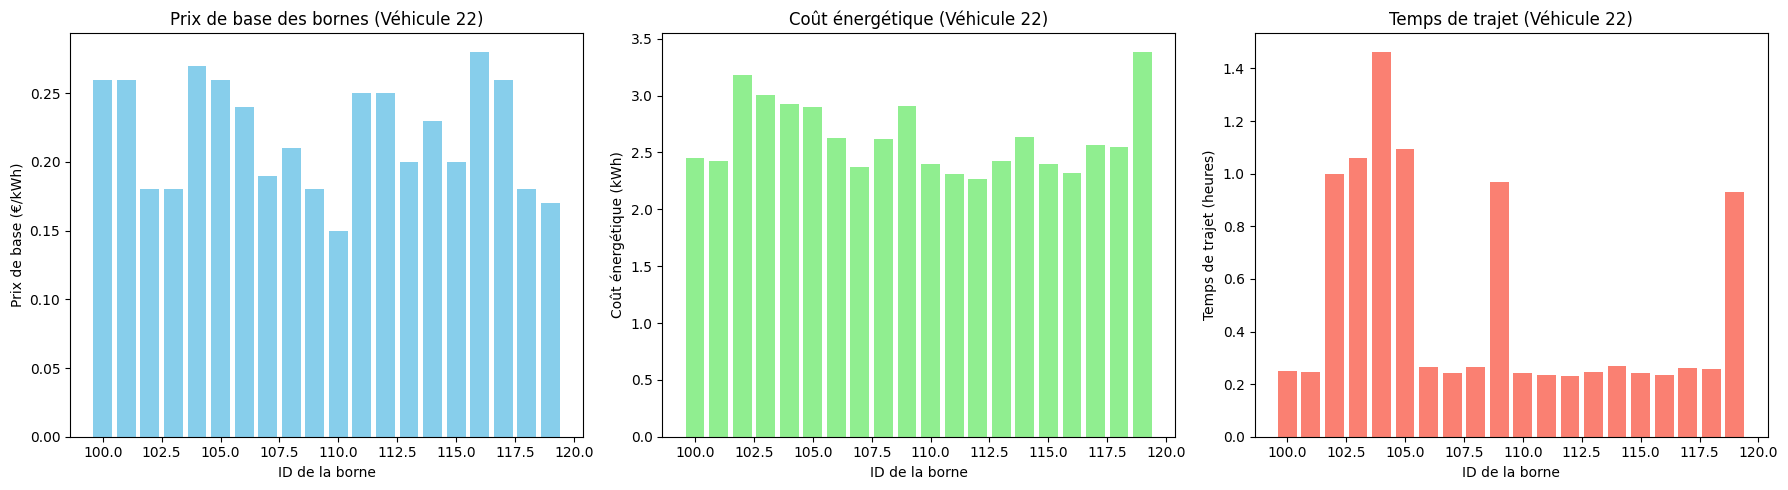

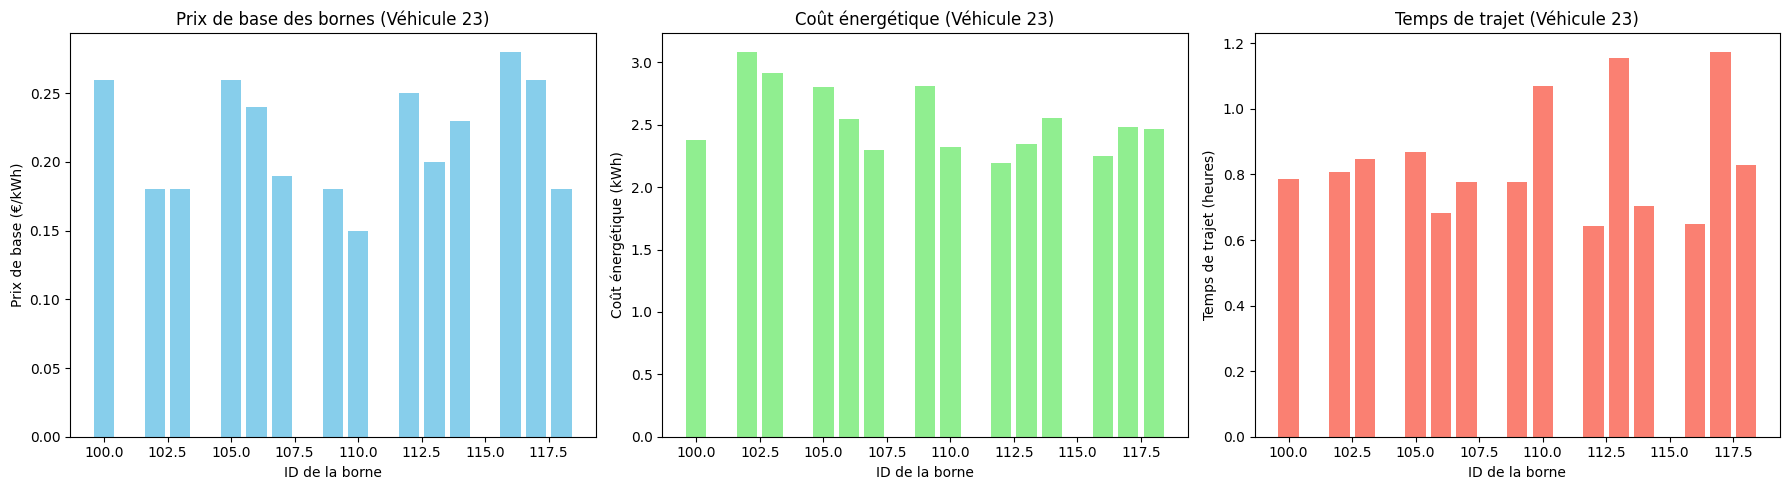

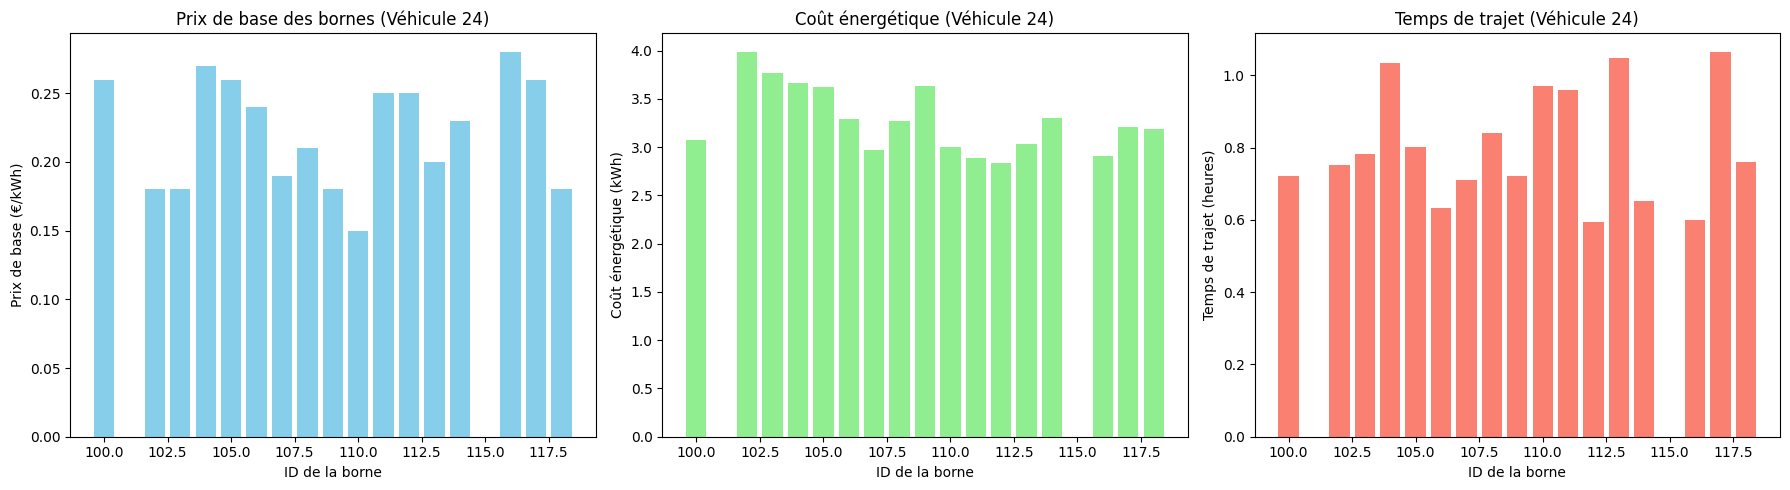

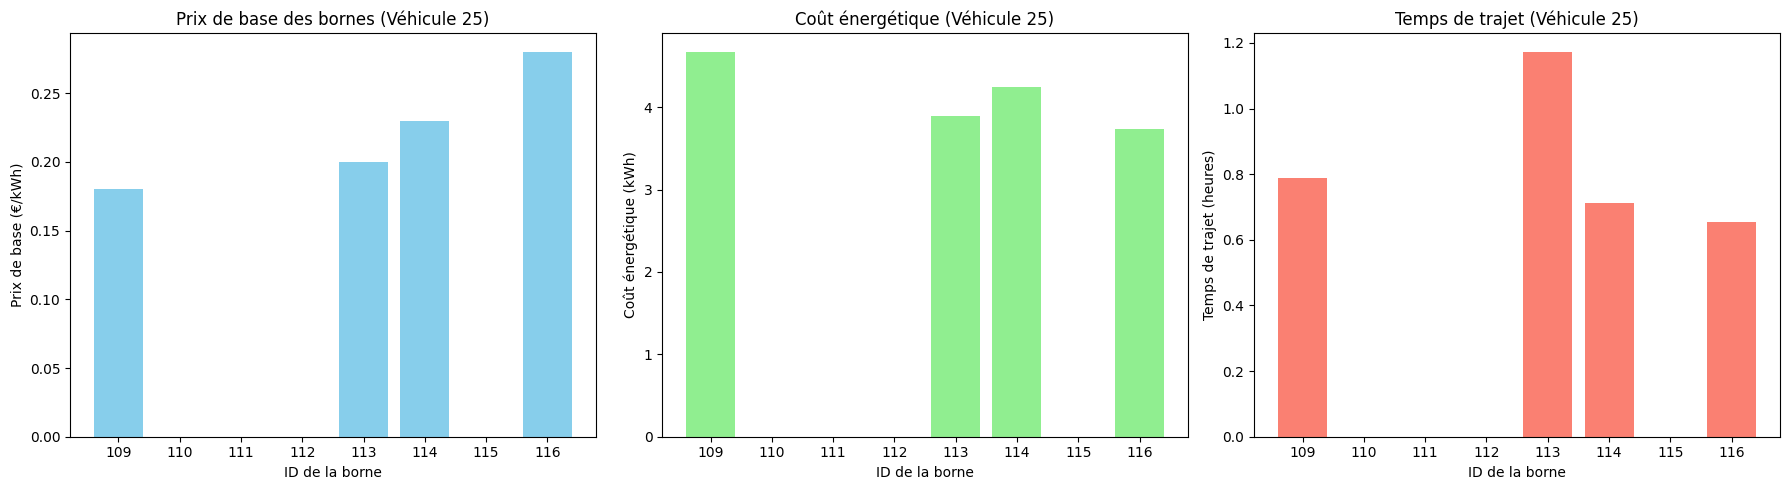

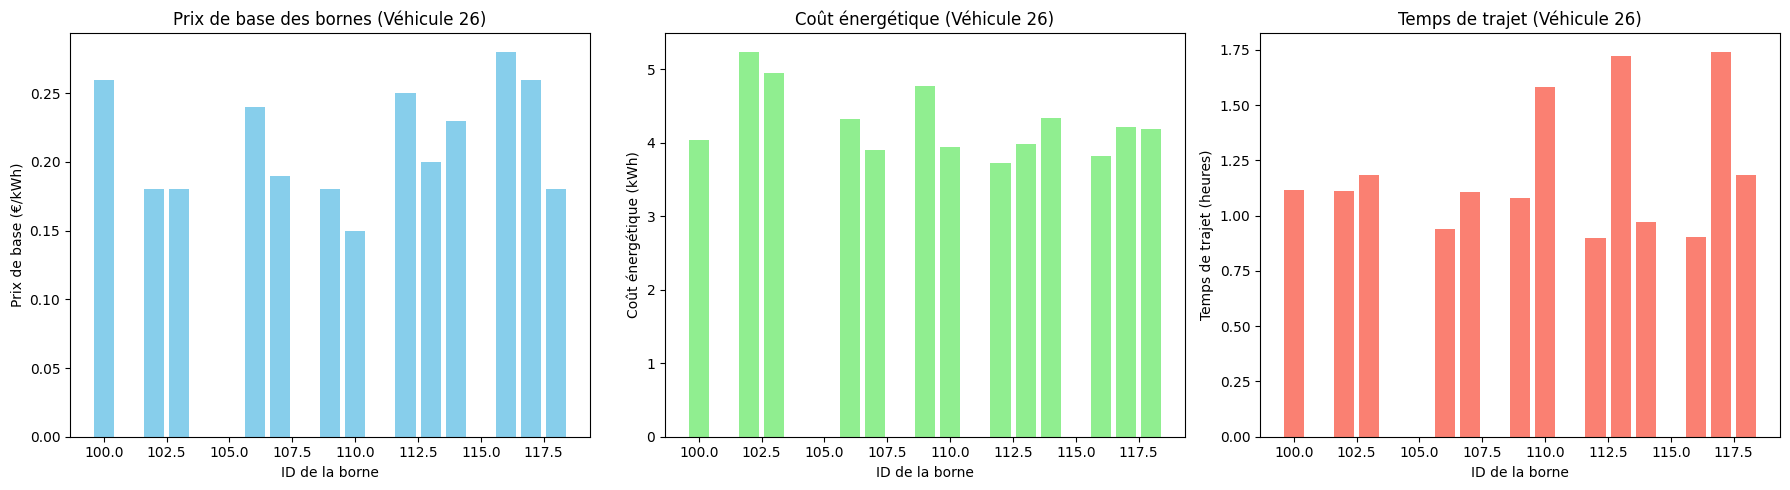

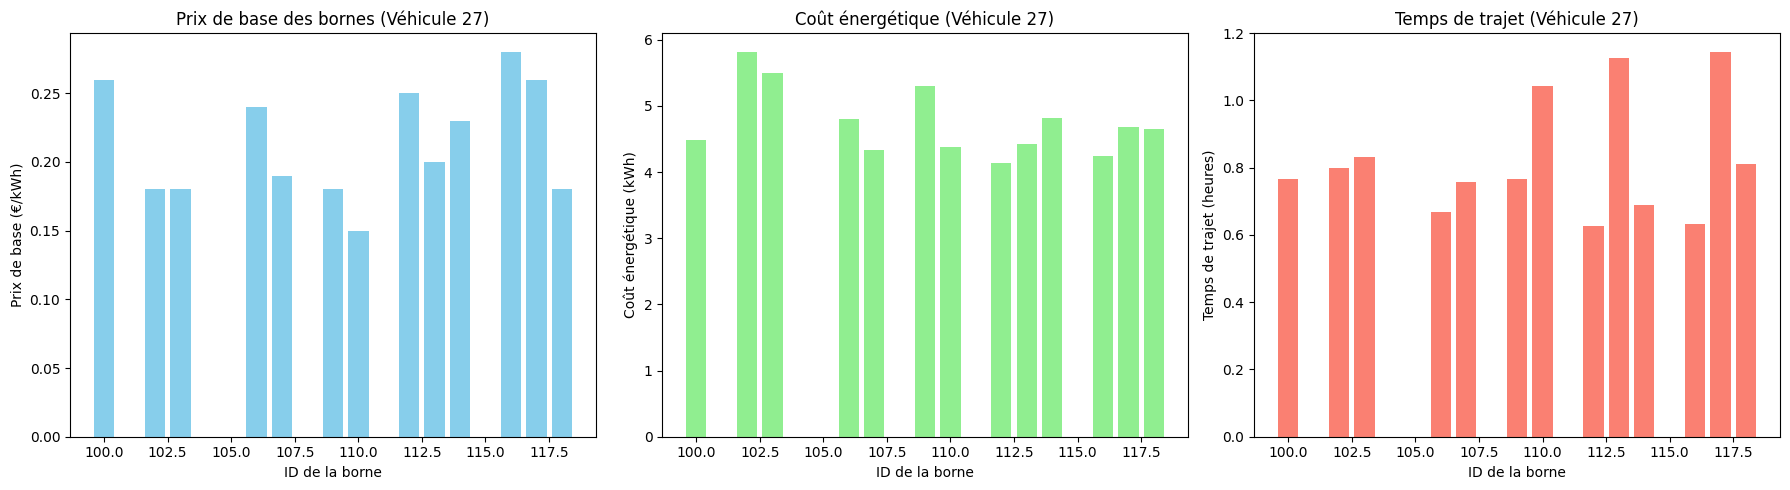

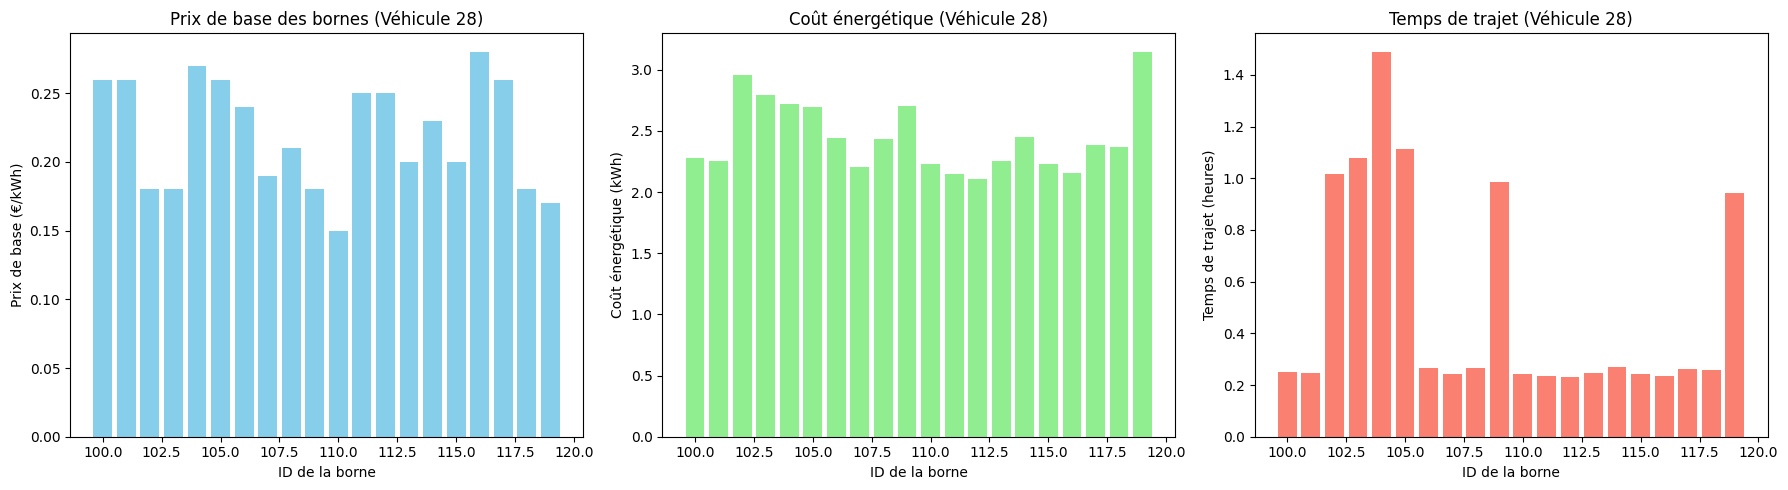

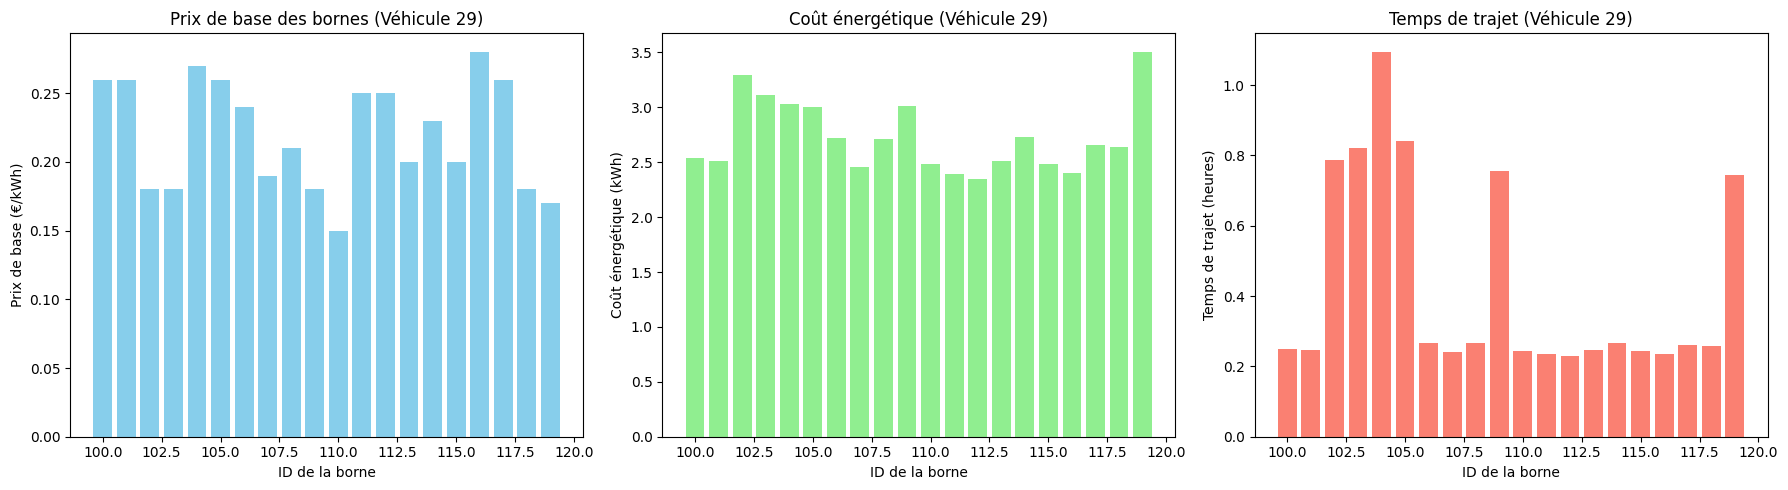

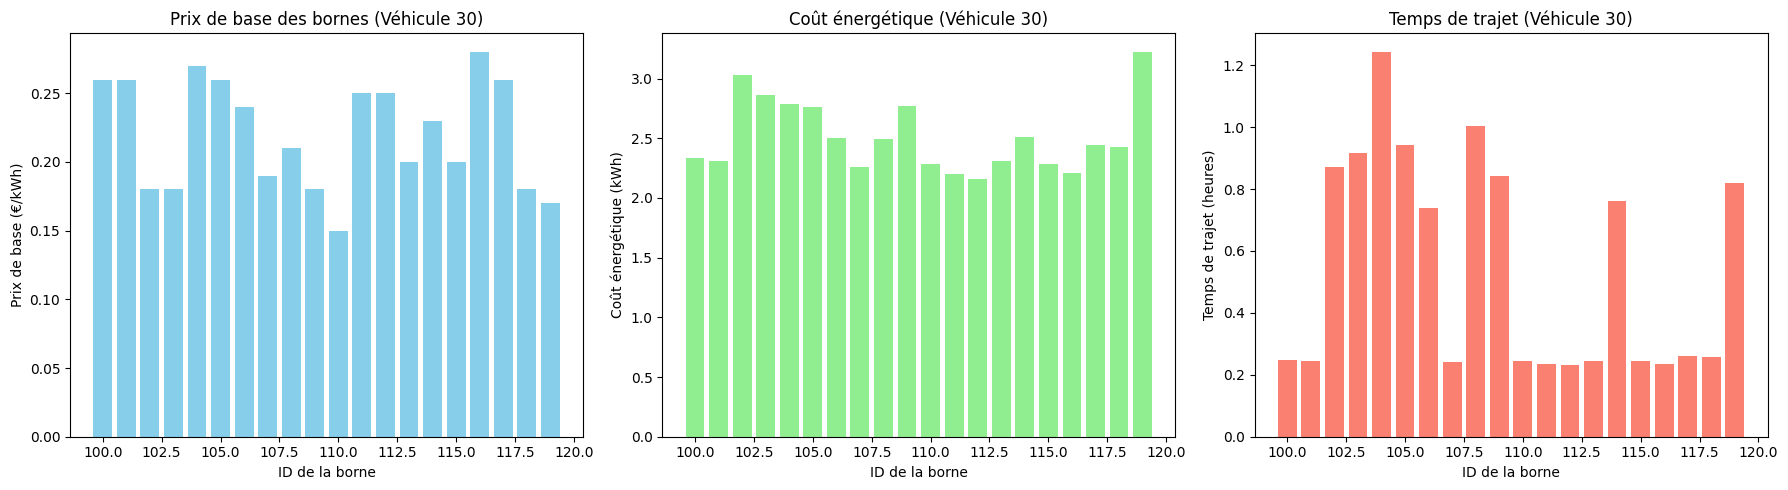

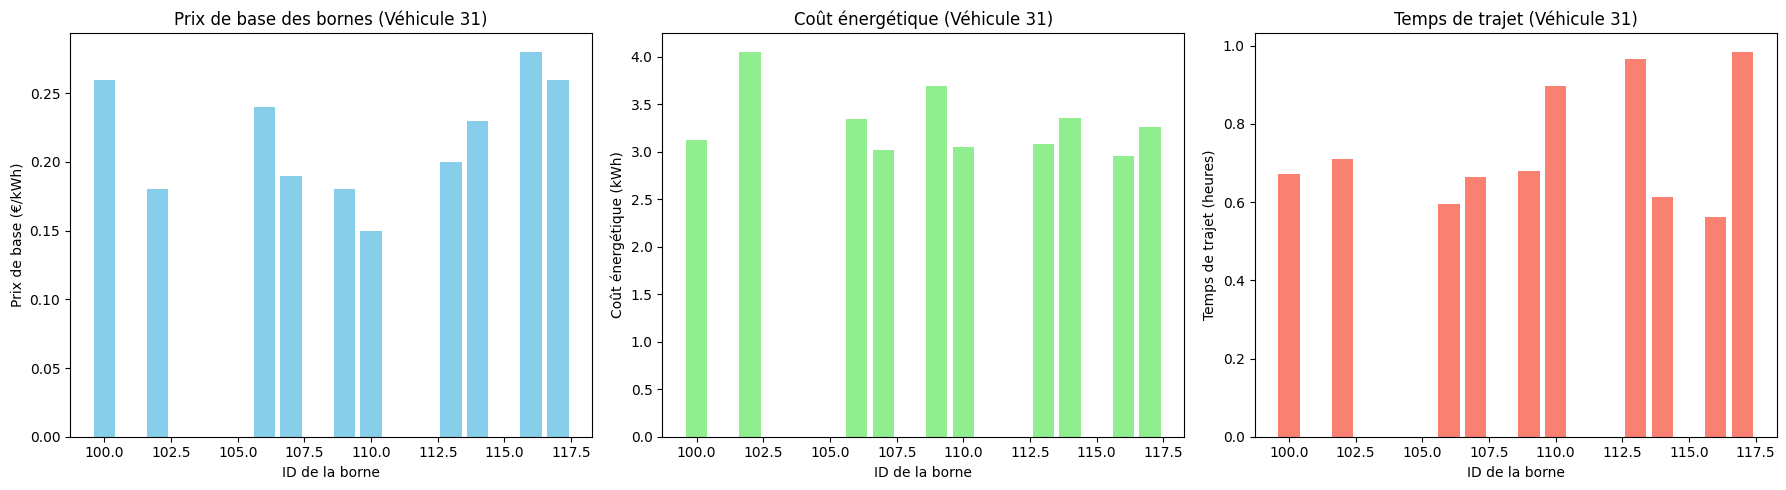

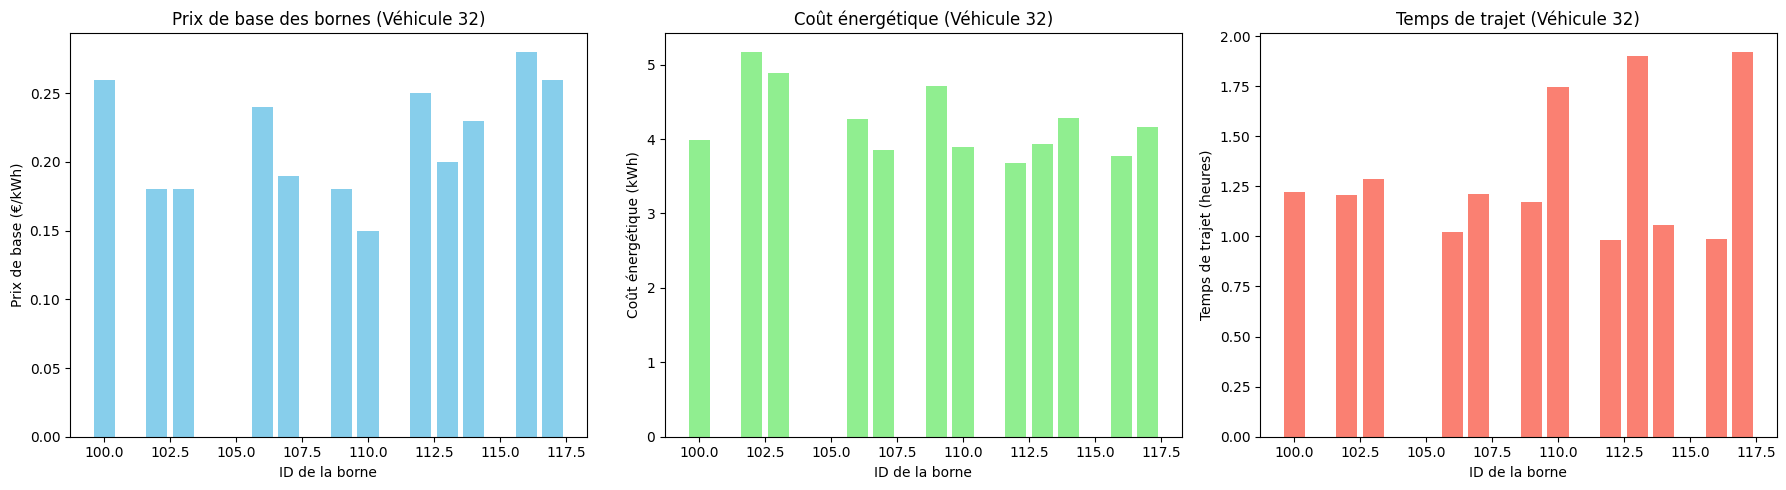

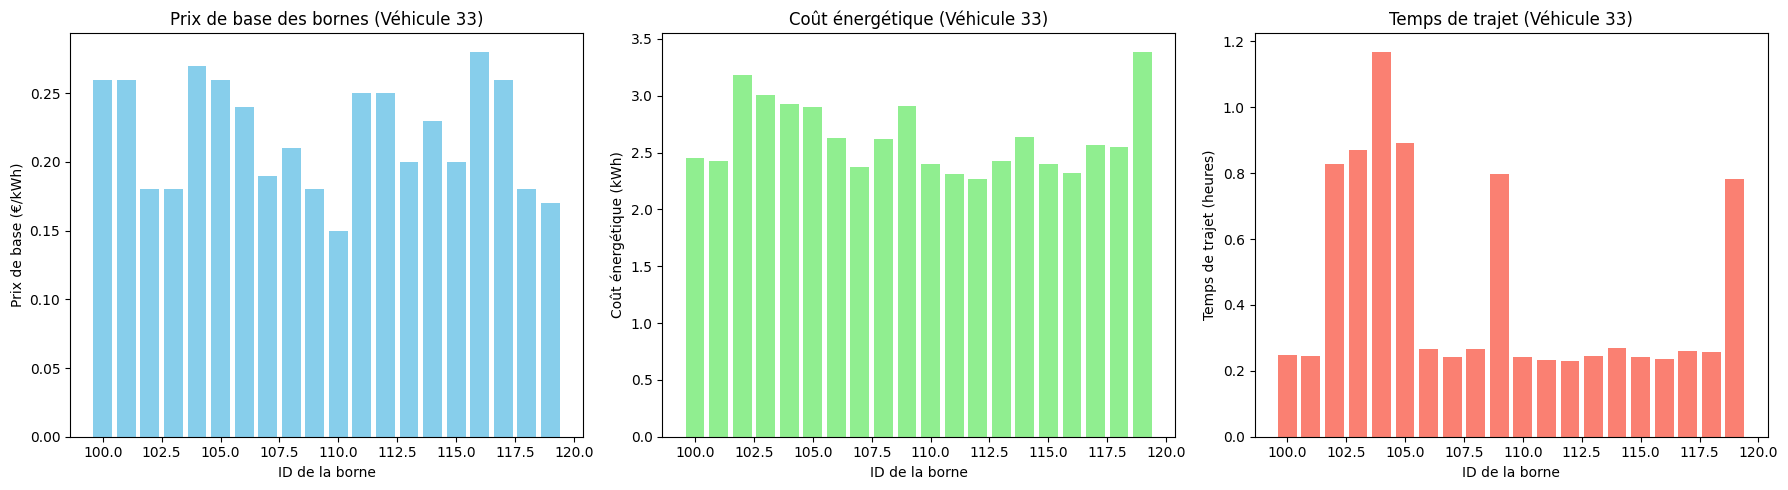

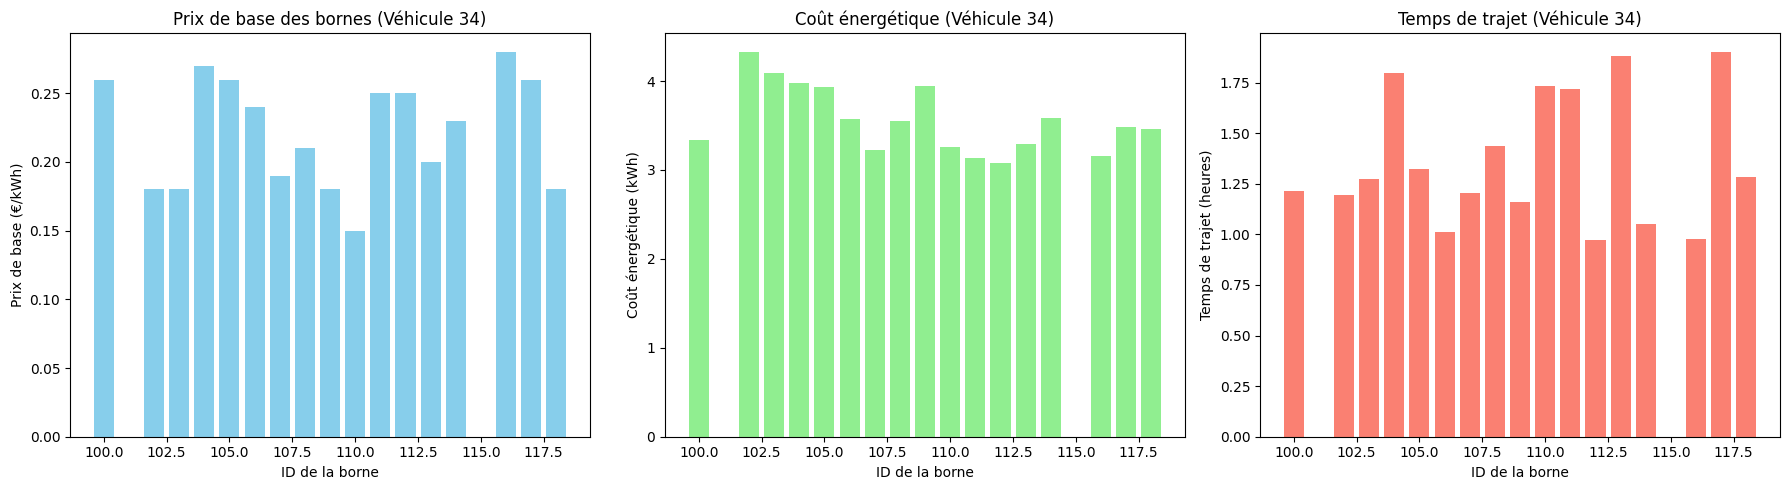

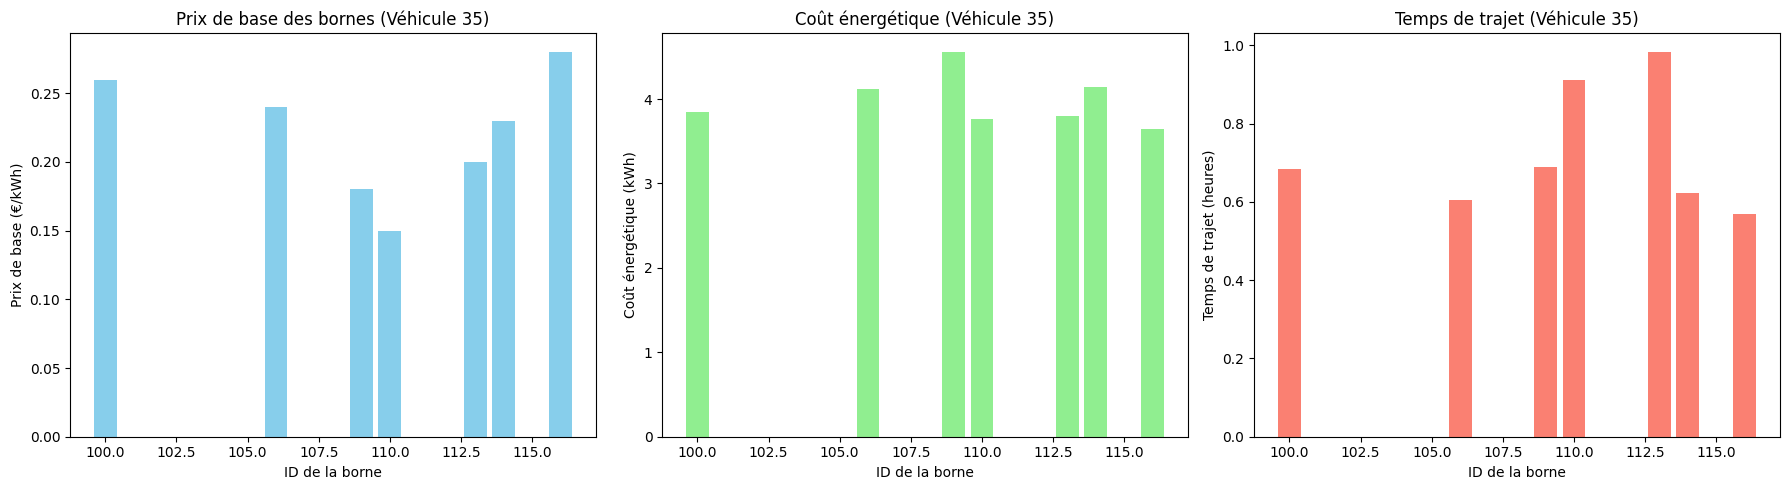

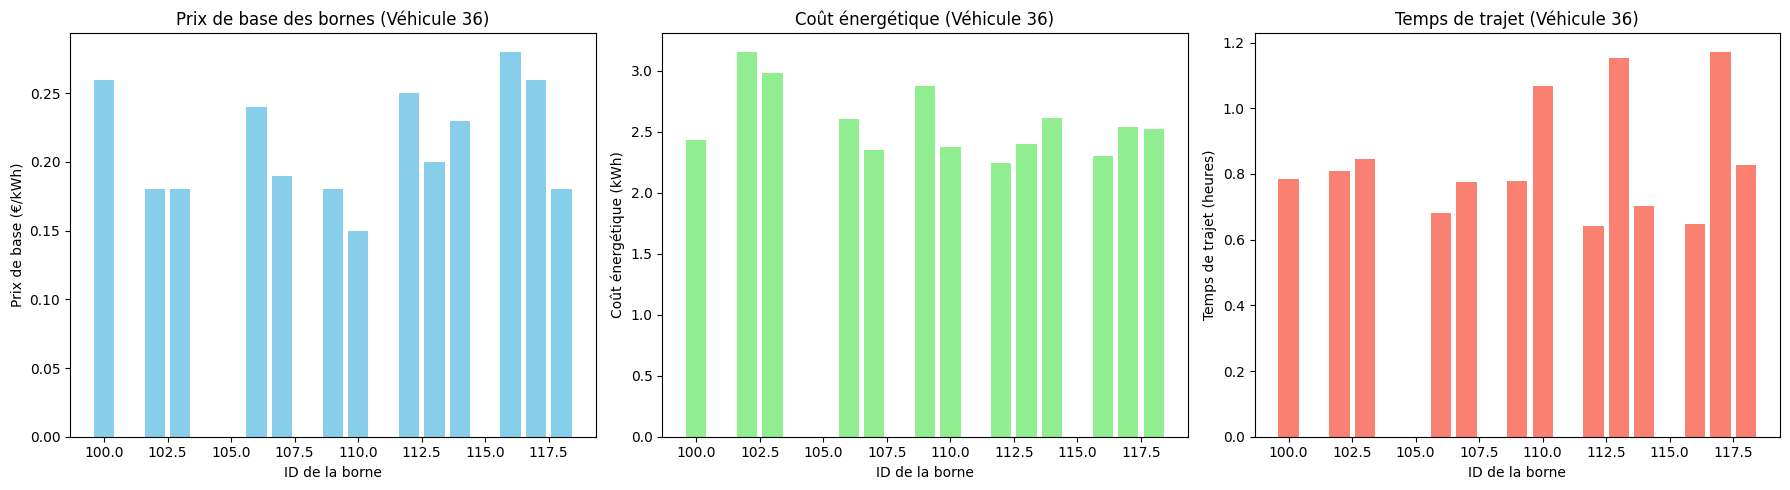

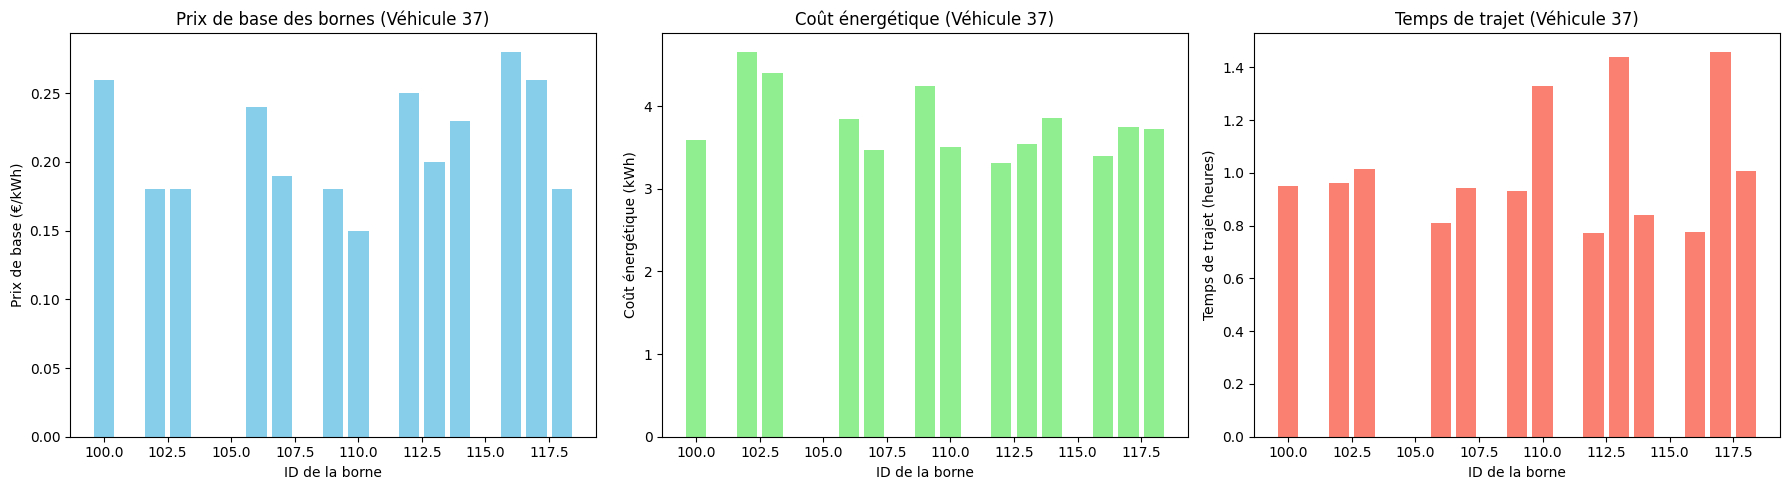

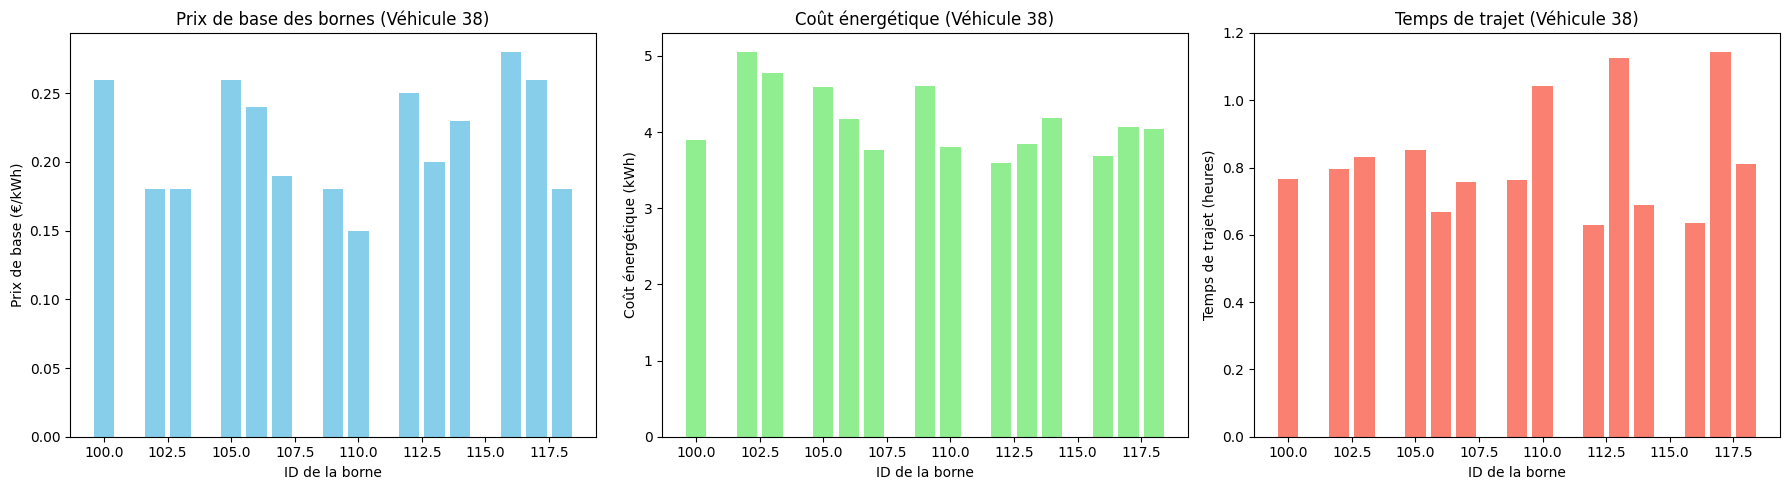

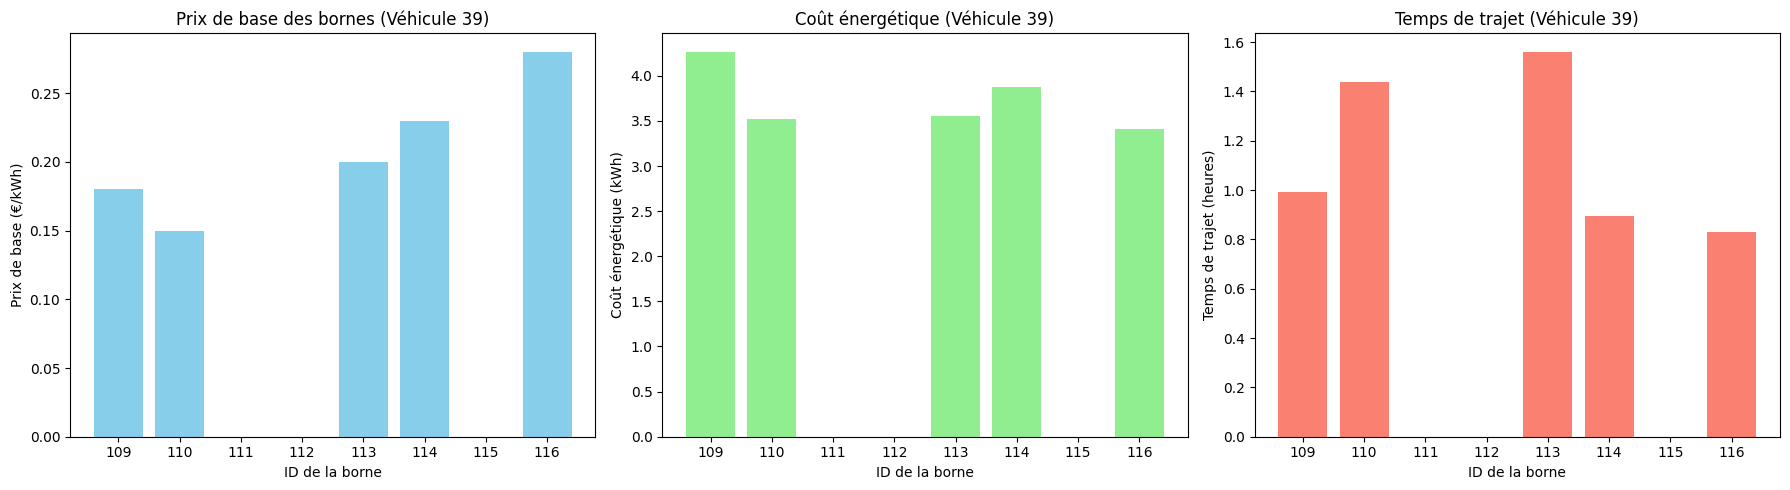

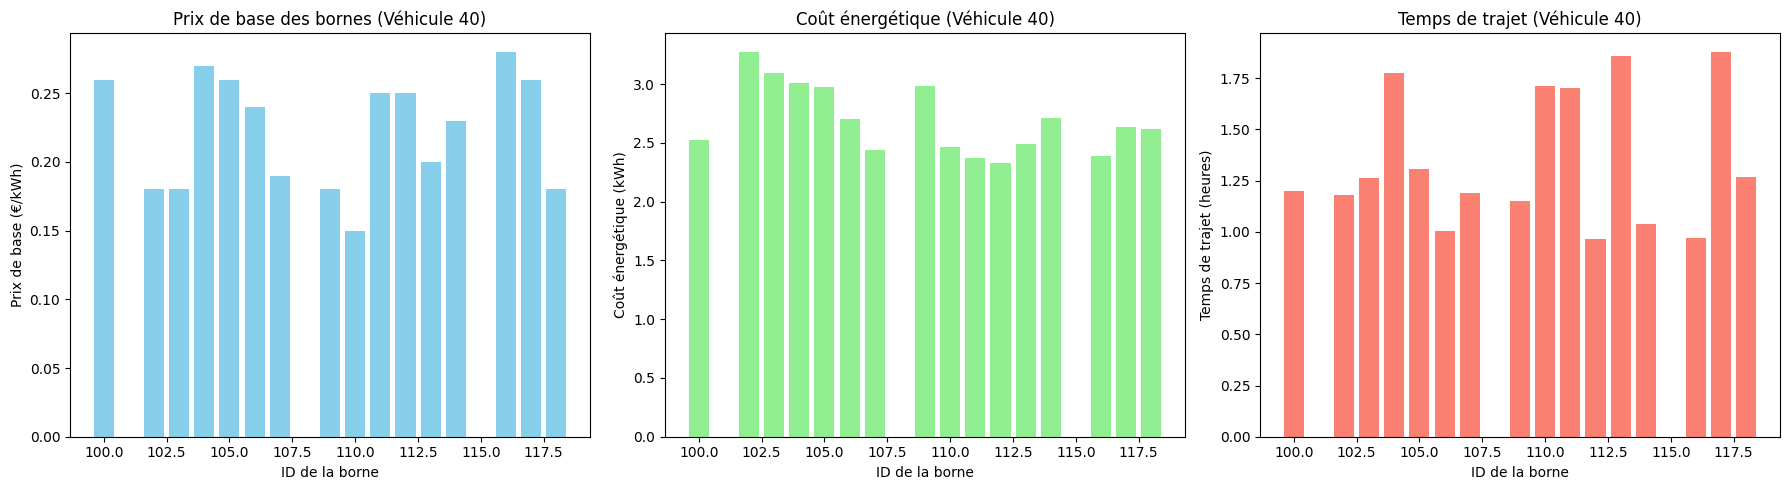

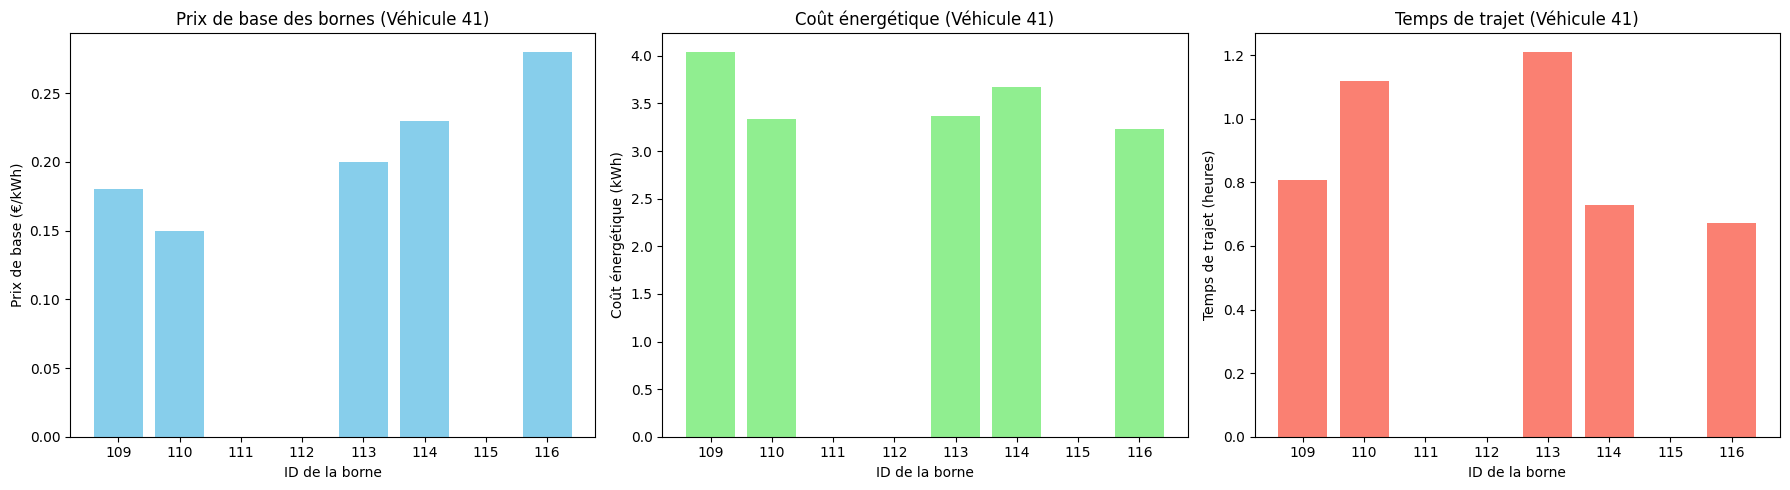

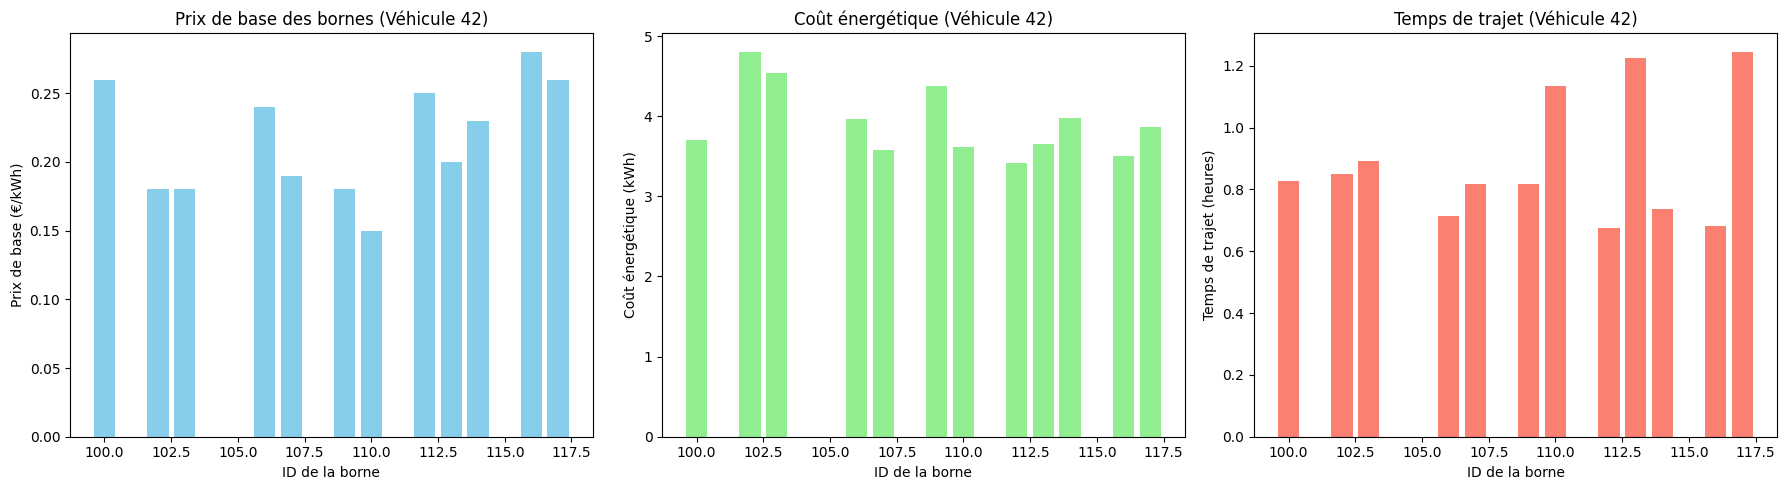

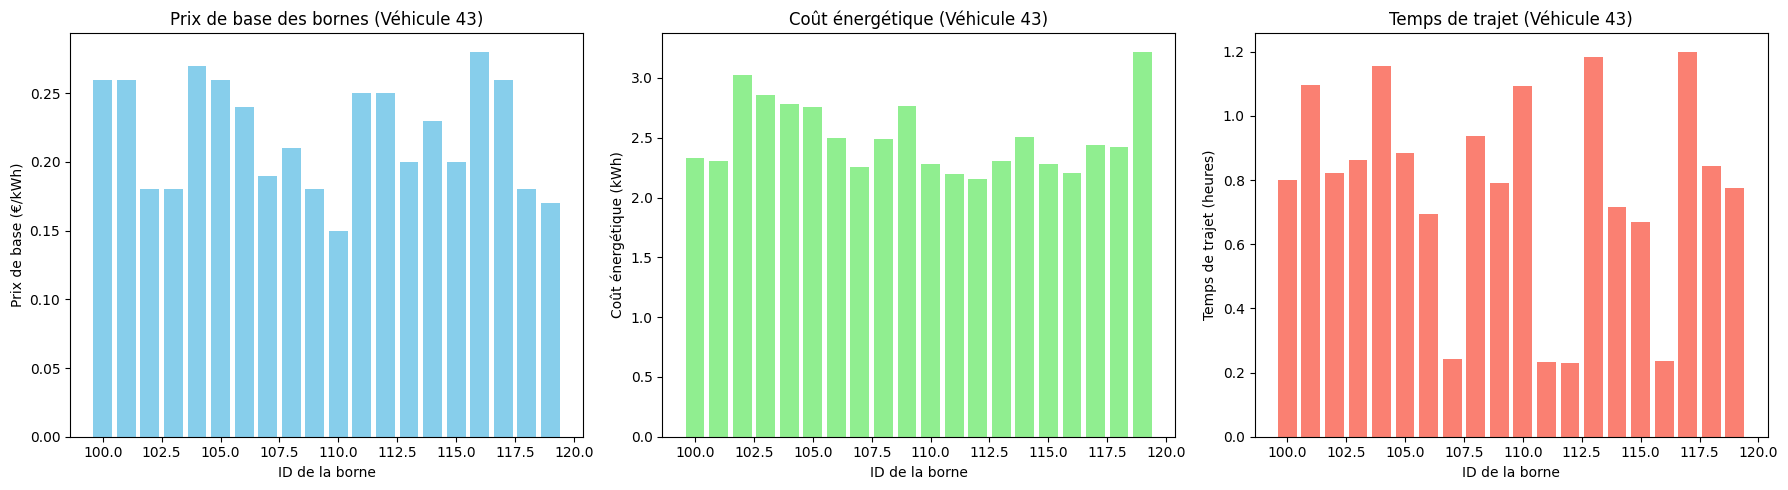

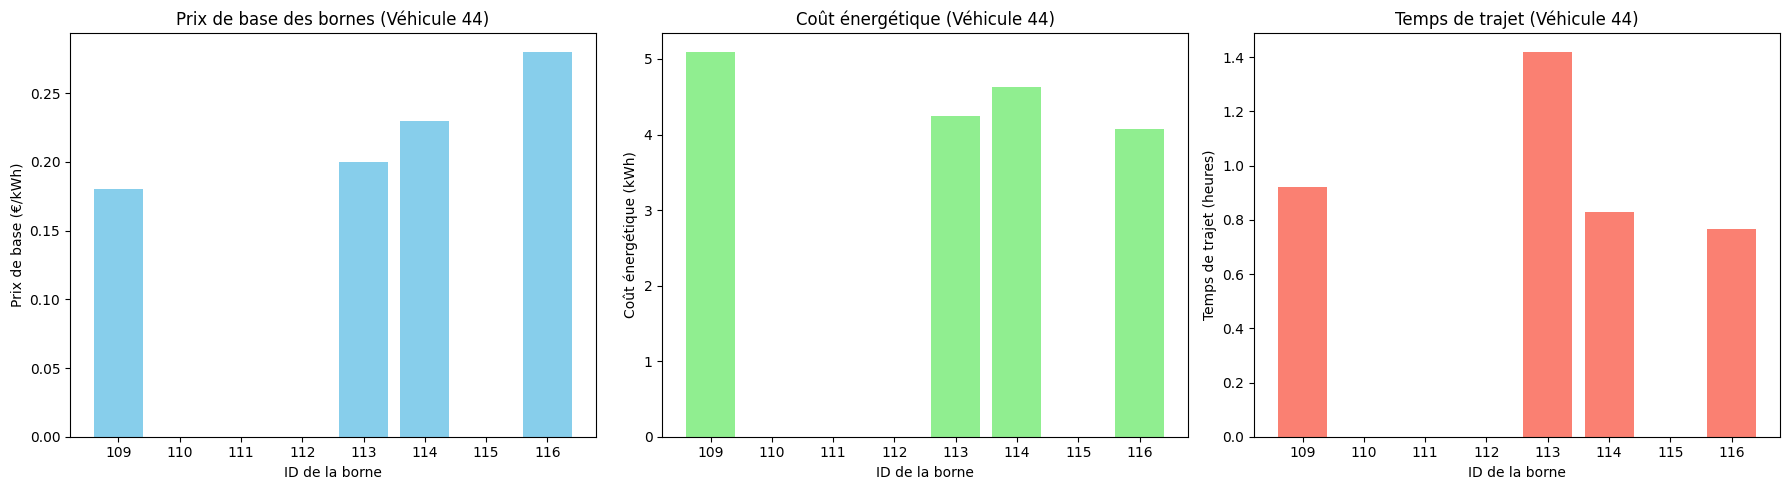

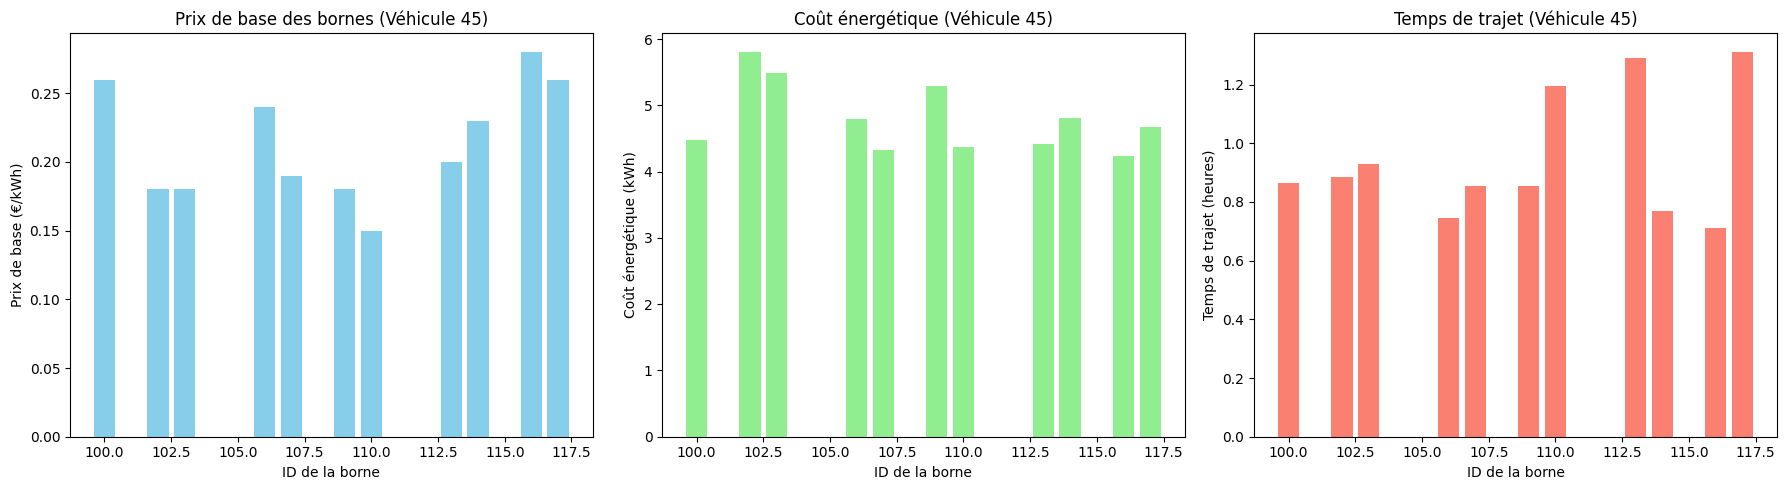

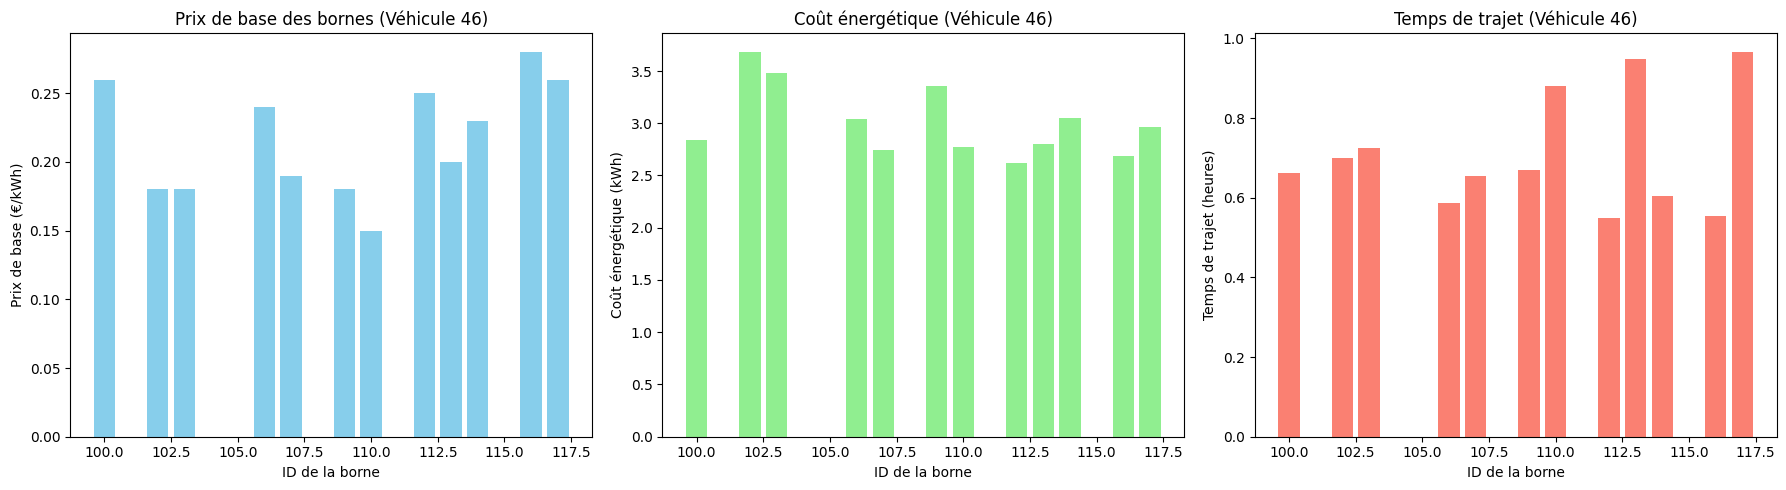

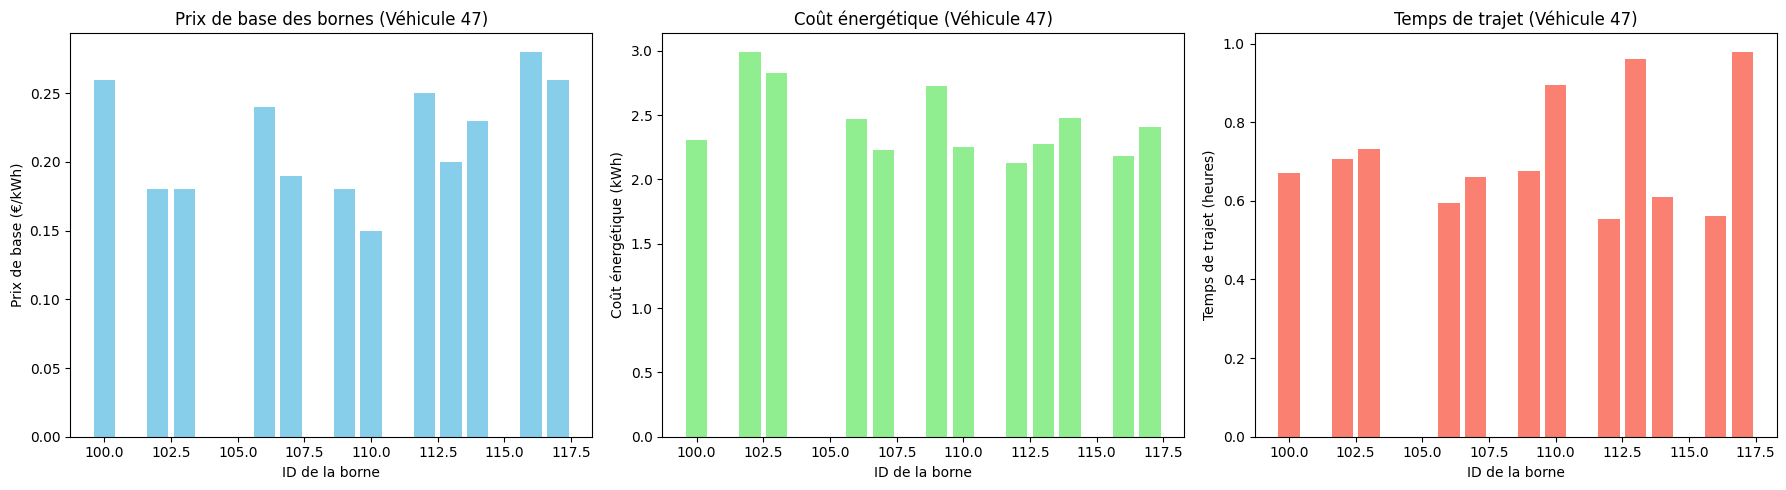

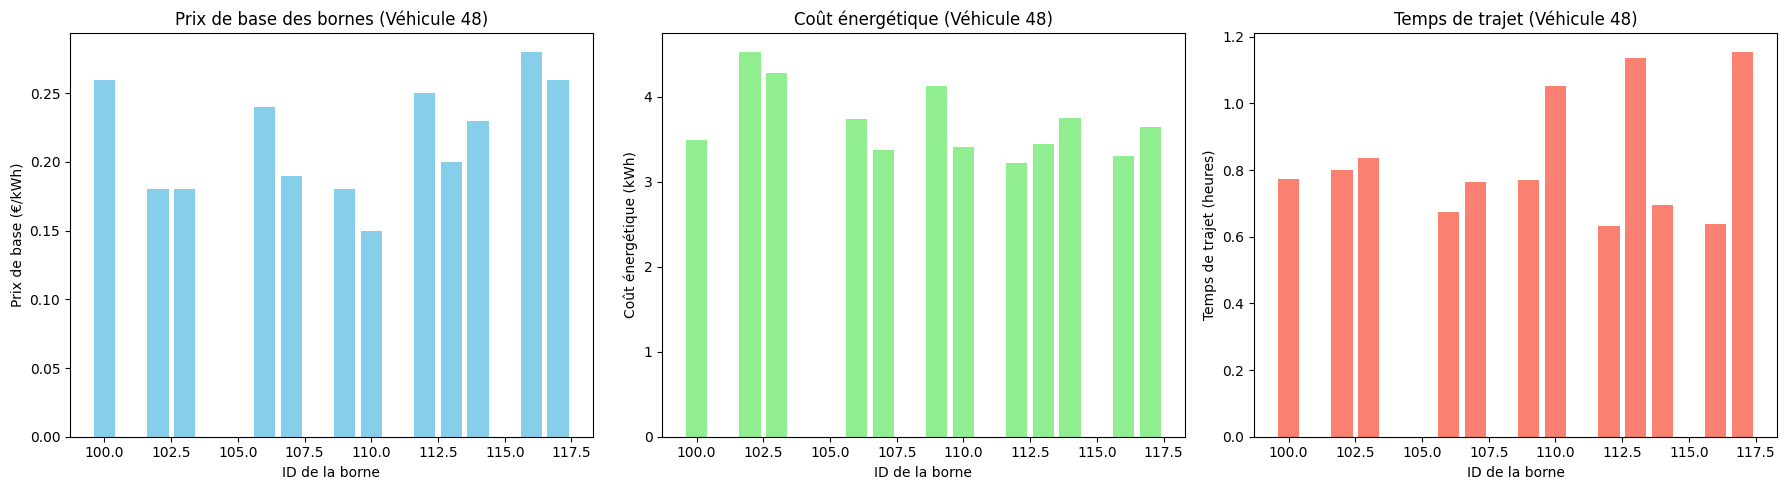

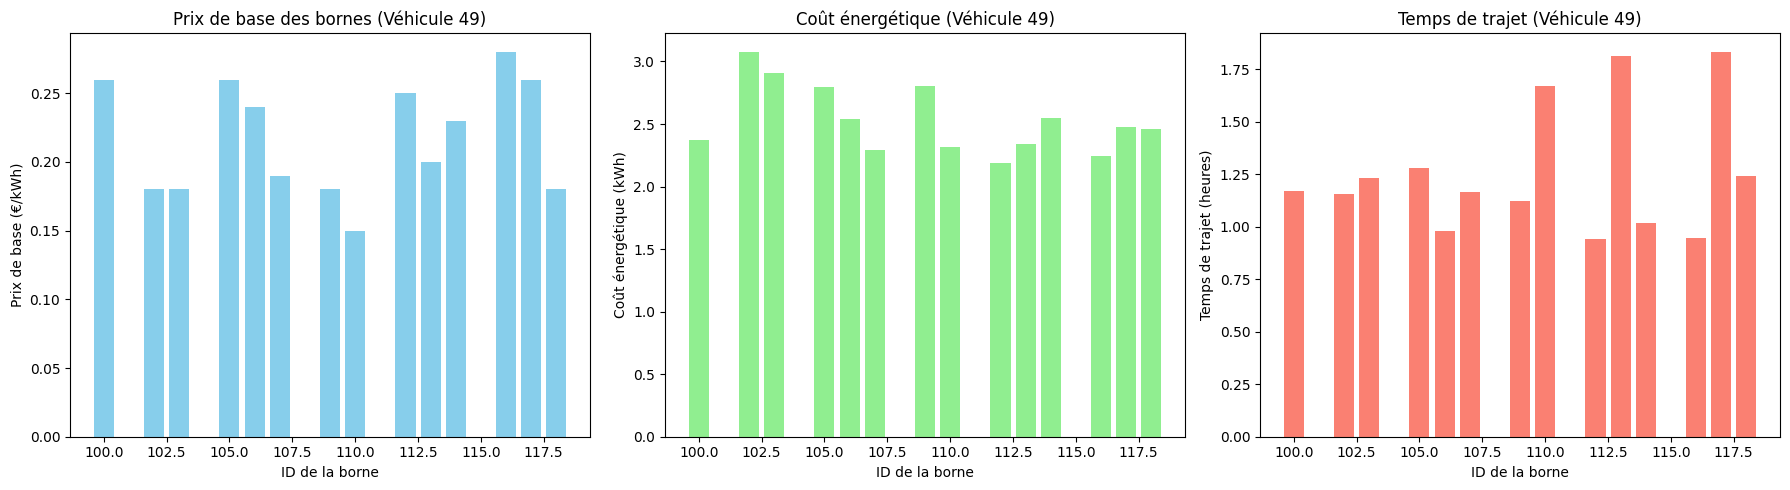

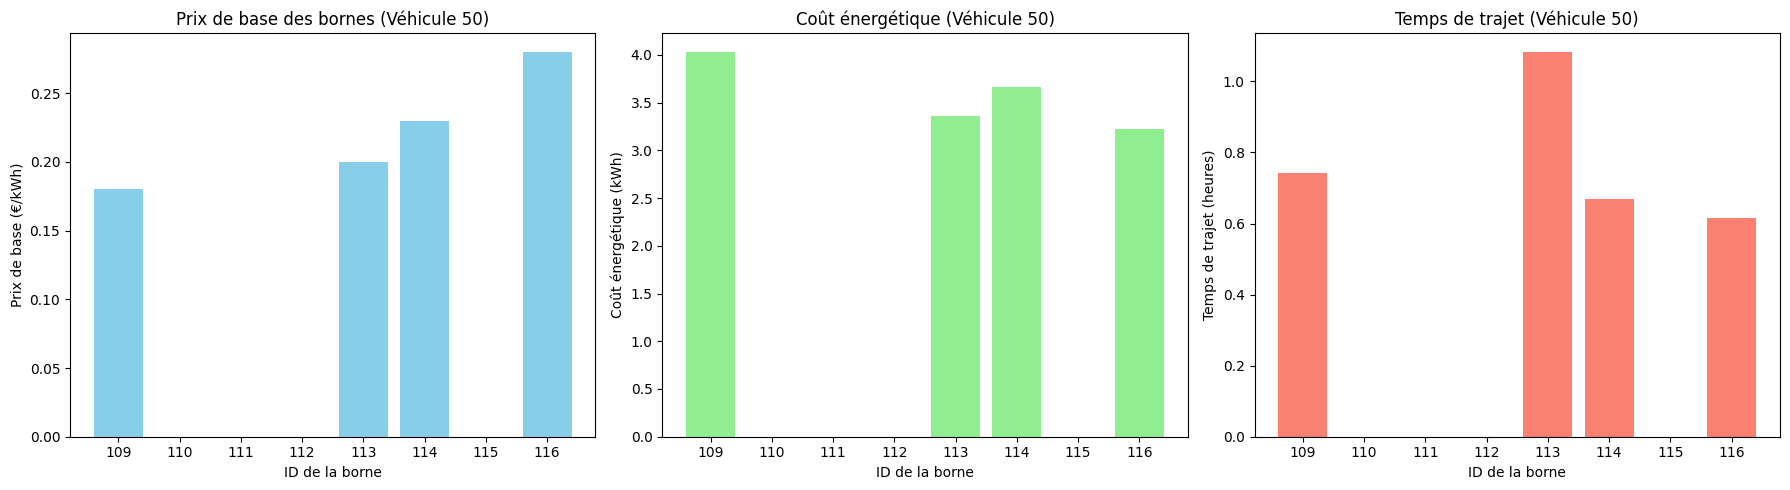

In [ ]:
start_node = ChargingStation(
    node_id=0,
    lat=start_point[0],
    lon=start_point[1],
    price=0.20,
    Renergie=500,
    Rtypes={"AC", "DC"},
    R_vitesse=30,
    Rconnecteurs=2
)
start_node.osmid = start_osmid

end_node = Node(
    node_id=1,
    lat=end_point[0],
    lon=end_point[1]
)
end_node.osmid = end_osmid

# Génération aléatoire des bornes autour du trajet
main_route_osmids = nx.shortest_path(G, source=start_osmid, target=end_osmid, weight='length')
sampled_osmids = random.sample(main_route_osmids, k=min(20, len(main_route_osmids)))
new_candidates = []
for i, osm_id in enumerate(sampled_osmids):
    node_data = G.nodes[osm_id]
    base_lat = node_data['y']
    base_lon = node_data['x']
    d_km = random.uniform(0, 5)
    theta = random.uniform(0, 2 * math.pi)
    delta_lat = (d_km / 111.32) * math.cos(theta)
    delta_lon = (d_km / (111.32 * math.cos(math.radians(base_lat)))) * math.sin(theta)
    cand_lat = base_lat + delta_lat
    cand_lon = base_lon + delta_lon
    price = round(random.uniform(0.15, 0.30), 2)
    Renergie = random.randint(300, 500)
    R_vitesse = round(random.uniform(0.83, 2.5), 1)
    Rconnecteurs = random.randint(1, 3)
    cand = ChargingStation(
        node_id=100 + i,
        lat=cand_lat,
        lon=cand_lon,
        price=price,
        Renergie=Renergie,
        Rtypes={"AC"},
        R_vitesse=R_vitesse,
        Rconnecteurs=Rconnecteurs,
        Rdispo=True
    )
    cand.osmid = ox.distance.nearest_nodes(G, X=cand_lon, Y=cand_lat)
    cand.price_amplitude = random.uniform(0.1, 0.3)
    cand.price_phase_shift = random.uniform(16, 20)
    new_candidates.append(cand)
    print(f"Station ID {cand.id} : Coordonnées ({cand.lat}, {cand.lon}), "
          f"Prix de base: {cand.price} €/kWh, Energie dispo: {cand.Renergie} kWh, "
          f"Vitesse de charge: {cand.R_vitesse} kWh/min, Connecteurs: {cand.Rconnecteurs}, Disponible: {cand.Rdispo}")

print("\nNombre de connecteurs disponibles pour chaque borne (initialement) :")
for station in new_candidates:
    print(f"Station ID {station.id} : {station.Rconnecteurs} connecteurs disponibles")

nodes = [start_node] + new_candidates + [end_node]

def generate_departure_time():
    if random.random() < 0.7:
        if random.random() < 0.5:
            departure = random.gauss(8, 0.5)
        else:
            departure = random.gauss(18, 0.5)
        departure = max(0, min(24, departure))
    else:
        departure = random.uniform(0, 24)
    return departure

profiles = ["urgent", "econome", "vert", "equilibrer"]
fleet = []
num_vehicles = 50
for i in range(num_vehicles):
    profile = random.choice(profiles)
    Bmax = random.uniform(40, 100)
    Ckm = random.uniform(0.15, 0.30)
    Binit = random.uniform(1, 3)
    vehicle = Vehicle(
        vehicle_id=i+1,
        Bmax=Bmax,
        Ckm=Ckm,
        Vmax=120,
        Veff=80,
        Tautonomie=4,
        Binit=Binit,
        profile=profile
    )
    vehicle.start_time = generate_departure_time()
    fleet.append(vehicle)

def plot_station_metrics_for_vehicle(vehicle, candidates, start_node, end_node, G, departure_time):
    candidate_ids = []
    prices = []
    energy_costs = []
    travel_times = []

    for cand in candidates:
        route = [start_node, cand, end_node]
        result = evaluate_route(vehicle, route, G, departure_time)
        obj, cost, arr, bat = result  # cost = (energy, recharge, travel_time)
        if obj is not None:
            candidate_ids.append(cand.id)
            prices.append(cand.price)
            energy_costs.append(cost[0])
            travel_times.append(cost[2])

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    axs[0].bar(candidate_ids, prices, color='skyblue')
    axs[0].set_title(f"Prix de base des bornes (Véhicule {vehicle.id})")
    axs[0].set_xlabel("ID de la borne")
    axs[0].set_ylabel("Prix de base (€/kWh)")

    axs[1].bar(candidate_ids, energy_costs, color='lightgreen')
    axs[1].set_title(f"Coût énergétique (Véhicule {vehicle.id})")
    axs[1].set_xlabel("ID de la borne")
    axs[1].set_ylabel("Coût énergétique (kWh)")

    axs[2].bar(candidate_ids, travel_times, color='salmon')
    axs[2].set_title(f"Temps de trajet (Véhicule {vehicle.id})")
    axs[2].set_xlabel("ID de la borne")
    axs[2].set_ylabel("Temps de trajet (heures)")

    plt.tight_layout()
    plt.show()
    fig.savefig(os.path.join(output_dir, f"station_metrics_vehicle_{vehicle.id}.png"))
    plt.close(fig)

for vehicle in fleet:
    plot_station_metrics_for_vehicle(vehicle, new_candidates, start_node, end_node, G, vehicle.start_time)

def plot_fleet_information(fleet, G, global_schedule):
    vehicle_ids = []
    departure_times = []
    objective_costs = []
    final_battery_levels = []

    for vehicle in fleet:
        vehicle_ids.append(vehicle.id)
        departure_times.append(vehicle.start_time)
        result = evaluate_route(vehicle, vehicle.route, G, vehicle.start_time, global_schedule)
        obj = result[0] if result[0] is not None else 0
        objective_costs.append(obj)
        final_battery_levels.append(result[3][-1] if result[3] else 0)

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    axs[0].bar(vehicle_ids, departure_times, color='mediumorchid')
    axs[0].set_title("Heure de départ par véhicule")
    axs[0].set_xlabel("ID du véhicule")
    axs[0].set_ylabel("Heure de départ (h)")

    axs[1].bar(vehicle_ids, objective_costs, color='lightcoral')
    axs[1].set_title("Coût objectif par véhicule")
    axs[1].set_xlabel("ID du véhicule")
    axs[1].set_ylabel("Coût objectif")

    axs[2].bar(vehicle_ids, final_battery_levels, color='lightseagreen')
    axs[2].set_title("Niveau de batterie final par véhicule")
    axs[2].set_xlabel("ID du véhicule")
    axs[2].set_ylabel("Batterie (kWh)")

    plt.tight_layout()
    plt.show()
    fig.savefig(os.path.join(output_dir, "fleet_information.png"))
    plt.close(fig)

def plot_station_price_variation(stations):
    times = np.linspace(0, 24, 100)
    fig, ax = plt.subplots(figsize=(10, 6))
    for station in stations:
        prices = [get_dynamic_price(station, t) for t in times]
        ax.plot(times, prices, label=f"Station {station.id}")
    ax.set_title("Variation des prix dynamiques sur 24h")
    ax.set_xlabel("Heure (h)")
    ax.set_ylabel("Prix dynamique (€/kWh)")
    ax.legend()
    plt.tight_layout()
    plt.show()
    fig.savefig(os.path.join(output_dir, "station_price_variation.png"))
    plt.close(fig)

# 9. Calcul Optimisation Globale de la flotte

On utilise la formule de théorie des jeux afin optimiser le gain commum des vehicules circulant en simultané

In [ ]:
def optimisation_globale_flotte(fleet, nodes, G, max_iter=5):
    global_station_schedule = {}
    fleet.sort(key=lambda v: v.start_time)

    for vehicle in tqdm(fleet, desc="Initialisation de la flotte"):
        init_route = initial_solution(vehicle, nodes, start_time=vehicle.start_time, global_schedule=global_station_schedule)
        final_route, final_obj = alns(vehicle, init_route, iterations=50, removal_rate=0.4,
                                       start_time=vehicle.start_time, global_schedule=global_station_schedule)
        vehicle.route = final_route
        result = evaluate_route(vehicle, final_route, G, vehicle.start_time, global_station_schedule)
        if result[0] is not None:
            _, _, _, _, local_updates, _ = result
            for station_id, intervals in local_updates.items():
                if station_id not in global_station_schedule:
                    global_station_schedule[station_id] = []
                global_station_schedule[station_id].extend(intervals)

    global_cost = 0
    for vehicle in fleet:
        res = evaluate_route(vehicle, vehicle.route, G, vehicle.start_time, global_station_schedule)
        if res[0] is not None:
            global_cost += res[0]
    print("Coût global initial :", global_cost)

    for it in range(max_iter):
        print(f"\nItération globale {it+1}")
        new_global_schedule = {}
        for vehicle in tqdm(fleet, desc="Optimisation globale"):
            new_route, new_obj = alns(vehicle, vehicle.route, iterations=50, removal_rate=0.4,
                                       start_time=vehicle.start_time, global_schedule=new_global_schedule)
            vehicle.route = new_route
            result = evaluate_route(vehicle, new_route, G, vehicle.start_time, new_global_schedule)
            if result[0] is not None:
                _, _, _, _, local_updates, _ = result
                for station_id, intervals in local_updates.items():
                    if station_id not in new_global_schedule:
                        new_global_schedule[station_id] = []
                    new_global_schedule[station_id].extend(intervals)
        new_global_cost = 0
        for vehicle in fleet:
            res = evaluate_route(vehicle, vehicle.route, G, vehicle.start_time, new_global_schedule)
            if res[0] is not None:
                new_global_cost += res[0]
        print("Coût global :", new_global_cost)
        if new_global_cost < global_cost:
            print("Amélioration globale trouvée.")
            global_cost = new_global_cost
            global_station_schedule = new_global_schedule
        else:
            print("Pas d'amélioration globale. Arrêt de l'itération.")
            break

    return fleet, global_station_schedule

print("\n----- Optimisation Globale de la Flotte sur 24h -----")
fleet, final_global_schedule = optimisation_globale_flotte(fleet, nodes, G, max_iter=5)


----- Optimisation Globale de la Flotte sur 24h -----


Initialisation de la flotte: 100%|██████████| 50/50 [49:21<00:00, 59.23s/it]


Coût global initial : 80.4856447179056

Itération globale 1


Optimisation globale: 100%|██████████| 50/50 [29:11<00:00, 35.04s/it]


Coût global : 80.4856447179056
Pas d'amélioration globale. Arrêt de l'itération.


# 10. Appels des fonctions graphiques


In [ ]:
for vehicle in fleet:
    display_route_info(vehicle.route, vehicle, G,
                       label=f"Véhicule {vehicle.id} (Départ à {format_time(vehicle.start_time)}) - Trajet Optimal",
                       start_time=vehicle.start_time,
                       global_schedule=final_global_schedule)
    plot_route(vehicle.route, G)

plot_fleet_information(fleet, G, final_global_schedule)
plot_station_price_variation(new_candidates)

--- Véhicule 36 (Départ à 00:04) - Trajet Optimal ---
Route (IDs): [0, 112, 1]
Coût énergétique: 2.25 kWh
Coût recharge: 16.75 €
Temps de trajet: 00:39
Coût total (détail): 19.64
Coût objectif (pondéré): 2.0607287239489227
Heures d'arrivée: ['00:04', '00:11', '00:42']
Niveaux de batterie: [1.772191115968796, np.float64(0.6778783206755981), 53.868296754882294]

Détails des arrêts de recharge :
  - Station ID 112: Arrivée à 00:18, Connecteurs libres: 0, Recharge de base: 24.7 min, Attente: 0.0 min, Temps total: 24.7 min, Prix dynamique: 0.31 €/kWh



--- Véhicule 18 (Départ à 01:08) - Trajet Optimal ---
Route (IDs): [0, 112, 1]
Coût énergétique: 2.19 kWh
Coût recharge: 19.46 €
Temps de trajet: 00:43
Coût total (détail): 22.36
Coût objectif (pondéré): 1.306715545890647
Heures d'arrivée: ['01:08', '01:15', '01:51']
Niveaux de batterie: [1.6361707488774289, np.float64(0.5702486318973425), 63.018693805145276]

Détails des arrêts de recharge :
  - Station ID 112: Arrivée à 01:22, Connecteurs libres: 0, Recharge de base: 28.9 min, Attente: 0.0 min, Temps total: 28.9 min, Prix dynamique: 0.31 €/kWh



--- Véhicule 28 (Départ à 03:43) - Trajet Optimal ---
Route (IDs): [0, 1]
Coût énergétique: 2.11 kWh
Coût recharge: 0.00 €
Temps de trajet: 00:14
Coût total (détail): 2.34
Coût objectif (pondéré): 0.34101868929138723
Heures d'arrivée: ['03:43', '03:56']
Niveaux de batterie: [2.66030940290183, np.float64(0.5506672462389424)]



--- Véhicule 41 (Départ à 04:18) - Trajet Optimal ---
Route (IDs): [0, 116, 107, 1]
Coût énergétique: 3.37 kWh
Coût recharge: 17.70 €
Temps de trajet: 00:40
Coût total (détail): 21.74
Coût objectif (pondéré): 2.215954267721494
Heures d'arrivée: ['04:18', '04:20', '04:49', '04:59']
Niveaux de batterie: [1.0475908069843993, np.float64(0.7708244899106489), 55.50595638129747, np.float64(53.389945525043785)]

Détails des arrêts de recharge :
  - Station ID 116: Arrivée à 04:24, Connecteurs libres: 1, Recharge de base: 25.3 min, Attente: 0.0 min, Temps total: 25.3 min, Prix dynamique: 0.32 €/kWh



--- Véhicule 13 (Départ à 04:43) - Trajet Optimal ---
Route (IDs): [0, 1]
Coût énergétique: 2.40 kWh
Coût recharge: 0.00 €
Temps de trajet: 00:14
Coût total (détail): 2.63
Coût objectif (pondéré): 0.3600003639051579
Heures d'arrivée: ['04:43', '04:57']
Niveaux de batterie: [2.510460758299027, np.float64(0.11031240920010266)]



--- Véhicule 48 (Départ à 07:00) - Trajet Optimal ---
Route (IDs): [0, 112, 1]
Coût énergétique: 3.23 kWh
Coût recharge: 12.55 €
Temps de trajet: 00:38
Coût total (détail): 16.41
Coût objectif (pondéré): 1.2530029806718719
Heures d'arrivée: ['07:00', '07:07', '07:38']
Niveaux de batterie: [1.5947511255089182, np.float64(0.02338109622283069), 51.56596652665129]

Détails des arrêts de recharge :
  - Station ID 112: Arrivée à 07:14, Connecteurs libres: 0, Recharge de base: 24.2 min, Attente: 0.0 min, Temps total: 24.2 min, Prix dynamique: 0.24 €/kWh



--- Véhicule 44 (Départ à 07:06) - Trajet Optimal ---
Route (IDs): [0, 116, 107, 1]
Coût énergétique: 4.25 kWh
Coût recharge: 18.17 €
Temps de trajet: 00:46
Coût total (détail): 23.18
Coût objectif (pondéré): 5.903956504317071
Heures d'arrivée: ['07:06', '07:07', '07:42', '07:52']
Niveaux de batterie: [1.2553792914738684, np.float64(0.9065269894602226), 67.40512173021088, np.float64(64.73797904429921)]

Détails des arrêts de recharge :
  - Station ID 116: Arrivée à 07:12, Connecteurs libres: 1, Recharge de base: 30.8 min, Attente: 0.0 min, Temps total: 30.8 min, Prix dynamique: 0.27 €/kWh



--- Véhicule 4 (Départ à 07:22) - Trajet Optimal ---
Route (IDs): [0, 112, 1]
Coût énergétique: NA
Coût recharge: NA
Temps de trajet: NA
Coût total (détail): NA
Coût objectif (pondéré): None
Heures d'arrivée: ['NA', 'NA']
Niveaux de batterie: [1.086978469375166, np.float64(0.022091507935046106)]



--- Véhicule 10 (Départ à 07:32) - Trajet Optimal ---
Route (IDs): [0, 112, 1]
Coût énergétique: NA
Coût recharge: NA
Temps de trajet: NA
Coût total (détail): NA
Coût objectif (pondéré): None
Heures d'arrivée: ['NA', 'NA']
Niveaux de batterie: [1.150696449221497, np.float64(0.1345612554985427)]



--- Véhicule 31 (Départ à 07:32) - Trajet Optimal ---
Route (IDs): [0, 106, 107, 1]
Coût énergétique: 3.38 kWh
Coût recharge: 8.25 €
Temps de trajet: 00:35
Coût total (détail): 12.21
Coût objectif (pondéré): 1.0544068249068375
Heures d'arrivée: ['07:32', '07:37', '07:58', '08:07']
Niveaux de batterie: [1.089250788436469, np.float64(0.0791905939869273), 41.235509657062636, np.float64(39.30079935745584)]

Détails des arrêts de recharge :
  - Station ID 106: Arrivée à 07:39, Connecteurs libres: 1, Recharge de base: 18.9 min, Attente: 0.0 min, Temps total: 18.9 min, Prix dynamique: 0.20 €/kWh



--- Véhicule 9 (Départ à 07:37) - Trajet Optimal ---
Route (IDs): [0, 106, 1]
Coût énergétique: 3.24 kWh
Coût recharge: 13.23 €
Temps de trajet: 00:47
Coût total (détail): 17.25
Coût objectif (pondéré): 1.4073814023817912
Heures d'arrivée: ['07:37', '07:42', '08:24']
Niveaux de batterie: [2.378470350096004, np.float64(1.3996988929468643), 66.6030171467126]

Détails des arrêts de recharge :
  - Station ID 106: Arrivée à 07:53, Connecteurs libres: 0, Recharge de base: 30.7 min, Attente: 0.0 min, Temps total: 30.7 min, Prix dynamique: 0.20 €/kWh



--- Véhicule 7 (Départ à 07:42) - Trajet Optimal ---
Route (IDs): [0, 107, 1]
Coût énergétique: NA
Coût recharge: NA
Temps de trajet: NA
Coût total (détail): NA
Coût objectif (pondéré): None
Heures d'arrivée: ['NA', 'NA']
Niveaux de batterie: [1.595492768547874, np.float64(0.7849307421451208)]



--- Véhicule 38 (Départ à 07:47) - Trajet Optimal ---
Route (IDs): [0, 116, 1]
Coût énergétique: 3.68 kWh
Coût recharge: 13.33 €
Temps de trajet: 00:38
Coût total (détail): 17.65
Coût objectif (pondéré): 4.855538709375111
Heures d'arrivée: ['07:47', '07:48', '08:25']
Niveaux de batterie: [2.9922160486633995, np.float64(2.6765203604255334), 51.878688310429794]

Détails des arrêts de recharge :
  - Station ID 116: Arrivée à 08:01, Connecteurs libres: 1, Recharge de base: 23.9 min, Attente: 0.0 min, Temps total: 23.9 min, Prix dynamique: 0.25 €/kWh



--- Véhicule 50 (Départ à 07:48) - Trajet Optimal ---
Route (IDs): [0, 114, 110, 1]
Coût énergétique: NA
Coût recharge: NA
Temps de trajet: NA
Coût total (détail): NA
Coût objectif (pondéré): None
Heures d'arrivée: ['NA', 'NA']
Niveaux de batterie: [1.0043823213848753, np.float64(0.3672035751566104)]



#11. Affichage des profils pour chaque véhicule

In [ ]:
# Affichage des profils pour chaque véhicule
print("\n--- Profils des véhicules ---")
for vehicle in fleet:
    print(f"Véhicule {vehicle.id} : Profil = {vehicle.profile}")


--- Profils des véhicules ---
Véhicule 36 : Profil = urgent
Véhicule 18 : Profil = vert
Véhicule 28 : Profil = econome
Véhicule 41 : Profil = urgent
Véhicule 13 : Profil = econome
Véhicule 48 : Profil = econome
Véhicule 44 : Profil = equilibrer
Véhicule 4 : Profil = vert
Véhicule 10 : Profil = urgent
Véhicule 31 : Profil = econome
Véhicule 9 : Profil = econome
Véhicule 7 : Profil = econome
Véhicule 38 : Profil = equilibrer
Véhicule 50 : Profil = econome
Véhicule 22 : Profil = equilibrer
Véhicule 12 : Profil = urgent
Véhicule 11 : Profil = vert
Véhicule 40 : Profil = urgent
Véhicule 23 : Profil = urgent
Véhicule 15 : Profil = econome
Véhicule 8 : Profil = vert
Véhicule 32 : Profil = vert
Véhicule 46 : Profil = econome
Véhicule 16 : Profil = urgent
Véhicule 2 : Profil = equilibrer
Véhicule 45 : Profil = vert
Véhicule 5 : Profil = equilibrer
Véhicule 25 : Profil = urgent
Véhicule 17 : Profil = equilibrer
Véhicule 27 : Profil = equilibrer
Véhicule 35 : Profil = econome
Véhicule 21 : Profi

# 12. Affichage de toutes les routes sur une seule carte avec légendes

In [ ]:
def add_route_to_map(route, G, m, color="red"):
    for i in range(len(route)-1):
        source = route[i]
        target = route[i+1]
        try:
            shortest_path = nx.shortest_path(G, source=source.osmid, target=target.osmid, weight='length')
            path_coords = [[G.nodes[n]['y'], G.nodes[n]['x']] for n in shortest_path]
            folium.PolyLine(locations=path_coords, color=color, weight=3).add_to(m)
        except Exception as e:
            print(f"Erreur entre {source.id} et {target.id}: {e}")

# Création d'une carte unique centrée sur le point de départ
center_lat = start_point[0]
center_lon = start_point[1]
m_all = folium.Map(location=[center_lat, center_lon], zoom_start=14)

# Liste de couleurs pour différencier les routes des véhicules
colors = ["red", "blue", "green", "purple", "orange", "darkred", "lightred", "beige", "darkblue", "darkgreen"]

# Tracé des routes et ajout des marqueurs pour chaque véhicule
for i, vehicle in enumerate(fleet):
    color = colors[i % len(colors)]
    add_route_to_map(vehicle.route, G, m_all, color=color)
    folium.Marker(
        location=[vehicle.route[0].lat, vehicle.route[0].lon],
        popup=f"Départ véhicule {vehicle.id}",
        icon=folium.Icon(color="black", icon="play")
    ).add_to(m_all)
    folium.Marker(
        location=[vehicle.route[-1].lat, vehicle.route[-1].lon],
        popup=f"Arrivée véhicule {vehicle.id}",
        icon=folium.Icon(color="black", icon="stop")
    ).add_to(m_all)

# Détermination des bornes utilisées au moins une fois
used_station_ids = set()
for vehicle in fleet:
    for node in vehicle.route:
        if node.is_charging_station:
            used_station_ids.add(node.id)

# Ajout des bornes sur la carte
all_charging_stations = [start_node] + new_candidates
for station in all_charging_stations:
    marker_color = "red" if station.id in used_station_ids else "blue"
    folium.Marker(
        location=[station.lat, station.lon],
        popup=(f"Borne ID {station.id}: Prix {station.price} €/kWh, "
               f"Energie dispo: {station.Renergie} kWh, "
               f"Vitesse de charge: {station.R_vitesse} kWh/min, "
               f"Connecteurs: {station.Rconnecteurs}"),
        icon=folium.Icon(color=marker_color, icon="flash")
    ).add_to(m_all)

# Légende pour les marqueurs (bornes utilisées/non utilisées, départ/arrivée)
legend_html = '''
<div style="position: fixed;
     bottom: 50px; left: 50px; width: 250px; height: 150px;
     border:2px solid grey; z-index:9999; font-size:14px;
     background-color:white; opacity:0.8;">
&nbsp;<b>Légende</b><br>
&nbsp;<i class="fa fa-map-marker fa-2x" style="color:red"></i>&nbsp; Borne utilisée<br>
&nbsp;<i class="fa fa-map-marker fa-2x" style="color:blue"></i>&nbsp; Borne non utilisée<br>
&nbsp;<i class="fa fa-map-marker fa-2x" style="color:black"></i>&nbsp; Départ/Arrivée<br>
</div>
'''
m_all.get_root().html.add_child(folium.Element(legend_html))

# Légende pour les lignes de route de chaque véhicule
legend_vehicle_html = f'''
<div style="position: fixed;
     bottom: 220px; left: 50px; width: 250px; height: {30 * len(fleet)}px;
     border:2px solid grey; z-index:9999; font-size:14px;
     background-color:white; opacity:0.8;">
&nbsp;<b>Lignes des Véhicules</b><br>
'''
for i, vehicle in enumerate(fleet):
    color = colors[i % len(colors)]
    legend_vehicle_html += f'&nbsp;<span style="background:{color};display:inline-block;width:15px;height:15px;margin-right:5px;"></span> Véhicule {vehicle.id}<br>'
legend_vehicle_html += '</div>'
m_all.get_root().html.add_child(folium.Element(legend_vehicle_html))

# Affichage de la carte unique avec toutes les routes, bornes et légendes
display(m_all)

In [ ]:
# Sauvegarde de la carte dans un fichier HTML
m_all.save("ALNS_Optimisation/carte_routes_vehicules.html")
print("Carte sauvegardée sous le nom 'carte_routes_vehicules.html'")

# 13. Zip le dossier contenant les graphiques

In [ ]:
# prompt: zip le dossier ALNS_Images

import zipfile
import os

def zip_folder(folder_path, zip_file_name):
    """Zips the specified folder and its contents."""
    try:
        with zipfile.ZipFile(zip_file_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
            for root, _, files in os.walk(folder_path):
                for file in files:
                    file_path = os.path.join(root, file)
                    arcname = os.path.relpath(file_path, folder_path)
                    zipf.write(file_path, arcname=arcname)
        print(f"Folder '{folder_path}' successfully zipped to '{zip_file_name}'")
    except FileNotFoundError:
        print(f"Error: Folder '{folder_path}' not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage: Replace 'ALNS_Images' with the actual folder name
zip_folder("ALNS_Optimisation", "ALNS_Optimisation.zip")